In [64]:
%matplotlib widget

import sys
import os

sys.path.insert(1, os.path.join(sys.path[0], '..'))

from datetime import datetime, timedelta
from pathlib import Path

import copy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import json

import warnings

from loader import Loader
lo = Loader()

from analyzer import Analyzer

from utils import _parse_template, save_figures

# Load Files 

In [65]:
json_timestamp_fnct = lambda x: datetime.strptime(x, '%Y%m%dT%H%M%S')
#json_timestamp_fnct = lambda x: datetime.strptime(x, '%Y%m%d_%H%M%S')
#csv_timestamp_fnct = lambda x: datetime.strptime(x, '%d.%m.%Y %H_%M_%S')
csv_timestamp_fnct = lambda x: datetime.strptime(x, '%m_%d_%Y %I_%M_%S %p')
h5_timestamp_fnct = lambda x: datetime.strptime(x, '%Y%m%d_%H%M%S')

parse_timestamp = True

attr_pattern_specs = {}
if parse_timestamp:
    attr_pattern_specs = {'timestamp':{'start':['^', '; ', '^'],
                                       'end':['_[^0-9]', ']', '_[^0-9]'],
                                       'trans_fnct': [json_timestamp_fnct, csv_timestamp_fnct, h5_timestamp_fnct],
                                       'must_contain': ['.json', '.csv', '.h5']
                                       }
                         }


In [66]:
# ============================= User input =============================
# Directory containing the measurement files

root = Path(r'/baltic/users/optolabdata/Experiments/ChristophWeilenmann')
#root = Path(r'Z:/Experiments/ChristophWeilenmann')
directory = root / Path(r'2024-04-23_cleansweep_5_before_anneal/')
directory = root / Path(r'2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/')

#directory = root / Path(r'2023-07-13_tests')


print(directory)

# Specify a pattern that the filename must contain. Only filenames containing the pattern will be loaded
must_contain = None
#must_contain = '(d1x1|d7x1|d8x1|d2x2|d7x2|d2x3|d2x4|d4x4|d10x4)'
#must_contain = ['P=\w{1,3}_']
#must_contain = '.json'
escape = False                           # must be False if pattern is a regex

# Specify metadata attributes to be read out of filename. 
# The attribute name will be set to the dictionary key (e.g. meas_name)
# The attribute value will be set to the string between the two patterns
user_attr_patterns = {'meas_name': {'start': '_', 'end': '\.'},
                      'chip': {'start': '(cleansweep_\d)', 'end': ''},
                     'cluster': {'start': '(c\d+x\d+)', 'end': '_'},
                     'device': {'start': '(d\d+x\d+)', 'end': '\.'},
                      'ambient':{'start': '(dark|light)', 'end': '_'},
                      'T':{'start': 'T=(\d+)', 'end': ''},
                      'P365':{'start': 'P365=(\d+)', 'end': ''}
                    }


# Example Regex: 'P=\w{1,3}_' (matches patterns: 'P=on_', 'P=0_', 'P=off_', 'P=170')
# Example Regex: 'd\d+x\d+_' (matches pattern: 'd10023x2346_')
# Example Regex: '_(?!(no|UV))' (matches patterns: '_lksjdflj' but not '_no' or '_UV')
# =====================================================================

/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement


In [67]:
attr_pattern_specs.update(user_attr_patterns)

lo.load_files(directory, must_contain=must_contain, attr_pattern_specs=attr_pattern_specs, escape=escape)

lo.print_files();

filename  \
0  20240425_165550_AWG_Test_cleansweep_5_c3x4_d4x1_dark_T=25_P365=0.2_no_50Ohm_terminator.h5   
1  20240502_181117_AWG_Test_cleansweep_5_c3x4_d9x3_dark_T=25_P365=0.2_no_50Ohm_terminator.h5   

            timestamp  \
0 2024-04-25 16:55:50   
1 2024-05-02 18:11:17   

                                                 meas_name          chip  \
0  165550_AWG_Test_cleansweep_5_c3x4_d4x1_dark_T=25_P365=0  cleansweep_5   
1  181117_AWG_Test_cleansweep_5_c3x4_d9x3_dark_T=25_P365=0  cleansweep_5   

  cluster device ambient   T P365  
0    c3x4   d4x1    dark  25    0  
1    c3x4   d9x3    dark  25    0

## Rename 

In [68]:
# rename_selection_generated = {}
# for i in range(0,47):
#     filename = lo.files[i]['filename']
#     new_filename = filename.replace('d14x4', 'd11x4')
#     #new_filename = new_filename.replace('c1x1', 'c1x4')
#     rename_selection_generated[i] = new_filename
    
# display(rename_selection_generated)


In [69]:
# # ============================= User input ============================= 
# rename_selection = \
# {
#     42: '20220923T150602_cleansweep_4_dark_T=25_c2x1_d4x2.json',
#     43: '20220923T150654_cleansweep_4_dark_T=25_c2x1_d4x2.json',
# }

# rename_selection = rename_selection_generated

# # ====================================================================== 

# lo.rename_files(rename_selection)
# lo.load_files(directory, must_contain=must_contain, attr_pattern_specs=attr_pattern_specs, escape=escape)

# Load Data

In [70]:
lo.load_raw_data()
an = Analyzer(lo, None)

default_meas_type_dict = {'IV': {'x':'Source', 'y':'Current'}, 'RV': {'x':'Source', 'y':'Resistance'},
                          'GV': {'x':'Source', 'y':'Conductance'}, 'JV': {'x':'Source', 'y':'Current Density'}, 
                          'G-t': {'x':'Time', 'y':'Conductance'}, 'J-t': {'x':'Time', 'y':'Current Density'},
                          'V-t': {'x':'Time', 'y':'Voltage'}, 'Source-t': {'x':'Time', 'y':'Source'}, 
                          'I-t': {'x':'Time', 'y':'Current'}, 'R-t': {'x':'Time', 'y':'Resistance'},
                          'P-t': {'x':'Time', 'y':['Power', 'P_avg_rolling', 'P_avg']}, 'ctml': {'x':'S', 'y': ['Resistance', 'R_corr']},
                          'gap_sweep':{'x':'Gap', 'y':'Resistance'}, 'E-t': {'x':'Time', 'y':'Energy'}, 'V_max-G': {'x':'V_max', 'y':'Conductance'}}

an.set_meas_type_dict(default_meas_type_dict)

default_axs_labels = {'Voltage': 'Applied Voltage [V]', 'Source': 'Measured Voltage [V]', 'Time': 'Time [s]', 
                      'Resistance': 'Resistance [ohm]', 'Conductance': 'Conductance [S]', 'Current': 'Current [A]', 
                      'Current Density': 'Current Density [A/cm^2]', 'S': 'gap [um]',
                      'Power': 'Power [W]', 'Gap': 'Gap [um]', 'Energy': 'Energy [J]', 'V_max': 'Pulse Voltage [V]'}

an.set_axs_labels(default_axs_labels)


default_title_template = '{meas_type}: {meas_name}, ({timestamp:%Y-%m-%d %H:%M:%S})'
default_legend_template = '{y_axis}'

default_plot_parameters = {\
                           'plot_type': '',
                           'x_scale':'linear',
                           'y_scale':'linear',
                           'x_lim': (),
                           'y_lim': (),
                           'title_template':default_title_template,
                           'legend_template':default_legend_template,
                           'x_scale_fn': None,
                           'y_scale_fn': None,
                           'plot_settings': {'linewidth': 2},
                           'grid': True,
                          }

# RESET Data 

In [71]:
# selection = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144]

# selection_to_remove = [k for k in an.measurements.keys() if k not in selection]


In [72]:
# for k in selection_to_remove:
#     an.measurements.pop(k, None)

# Clean All Data 

## Remove 0

In [73]:
# Can remove a measurement if no data left
# an.rm_zero(thr=5e-2)

## Set Start Time to 0

In [74]:
all_measurements = list(an.measurements.keys())
selection = an.set_selection(all_measurements) 
value = 0
an.set_start_time_to_value_selection(value)

True

## Calc conductance 

In [75]:
all_measurements = list(an.measurements.keys())
selection = an.set_selection(all_measurements) 
an.calc_conductance(calc_resistance=False, v_app=0, two_channels=False)

True

# Add custom Attributes 

In [76]:
all_measurements = list(an.measurements.keys())
selection = an.set_selection(all_measurements) 
#an.print_measurements(selection=selection)

In [77]:
# ============= Add Voltage at beginning of measurement as attribute ============

attr_map = {}
attr_map['V0'] = []
attr_map['V'] = []
attr_map['V_read'] = []
attr_map['idx'] = []

for idx in selection:
    attr_map['idx'].append(idx)

    data = an.measurements[idx]['data']
    
    try:
        metadata = an.measurements[idx]['metadata']
        attr_map['V'].append(metadata['source_parameters']['AWG-5064']['CH1']['V'])
    except KeyError:
        attr_map['V'].append(None)

    try:
        metadata = an.measurements[idx]['metadata']
        attr_map['V_read'].append(metadata['source_parameters']['AWG-5064']['CH1']['read_V'])
    except KeyError:
        attr_map['V_read'].append(None)
        
    try:
        attr_map['V0'].append(np.round(data['Voltage'].iloc[1], decimals=1)) 
    except IndexError :
        attr_map['V0'].append(None)

        
an.add_attributes_to_selection(attr_map)


True

# Show All Measurements

In [78]:
only_ch2 = [m for m in all_measurements if type(m) is int]
sel = all_measurements
#sel = only_ch2

printed_measurements = an.print_measurements(selection=sel, exclude_keys=['data', 'metadata', 'V', 'V_read'])

timestamp  \
0 2024-04-25 16:55:50   
1 2024-05-02 18:11:17   

                                                 meas_name          chip  \
0  165550_AWG_Test_cleansweep_5_c3x4_d4x1_dark_T=25_P365=0  cleansweep_5   
1  181117_AWG_Test_cleansweep_5_c3x4_d9x3_dark_T=25_P365=0  cleansweep_5   

  cluster device ambient   T P365   V0  idx  
0    c3x4   d4x1    dark  25    0 -0.0    0  
1    c3x4   d9x3    dark  25    0 -0.0    1

# Manipulate Selection

In [79]:
selection_to_manipulate = [0,1]
print(selection_to_manipulate)

[0, 1]


In [80]:
if not hasattr(an, 'manipulated_selections'):
    an.manipulated_selections = {}
an.manipulated_selections['normal'] = {k:[k] for k in selection_to_manipulate}

### Pick Points Trigger

In [81]:
sel = selection_to_manipulate
act_on_selections = 'normal'

In [82]:
if not 'triggered_normal_selections' in an.manipulated_selections:
    an.manipulated_selections['triggered_normal_selections'] = {}
    
skip_known = False

In [83]:
tr_level = {0:0.78, 1:1.18}

n_points_per_pulse = 1
n_points_before_pulse_end = 2
active_edge = 'falling'
fill_above_trigger_level_points = 100

In [84]:
triggered_selections = {}
for s in sel:
    if skip_known and (s in an.manipulated_selections['triggered_normal_selections']):
        continue
    
    act_sel = an.manipulated_selections[act_on_selections][s]
    try:
        trigger_level = tr_level[s]
    except Exception:
        an.manipulated_selections['triggered_normal_selections'][s] = act_sel
        continue

    an.set_selection(act_sel)
    an.manipulated_selections['triggered_normal_selections'][s] = an.pick_points_trigger(trigger_level, n_points_per_pulse=n_points_per_pulse, n_points_before_pulse_end=n_points_before_pulse_end, 
                                                                                  active_edge=active_edge, fill_above_trigger_level_points=fill_above_trigger_level_points, appendix='trig_norm')
    #an.manipulated_selections['triggered_selections'][s], mask, mask_above_trigger_level = pick_points_trigger_new(trigger_level, n_points_per_pulse=n_points_per_pulse, n_points_before_pulse_end=n_points_before_pulse_end, 
    #                                                                                                               active_edge=active_edge, fill_above_trigger_level_points=fill_above_trigger_level_points)
    
#print(an.manipulated_selections['triggered_selections'])

# Plot Selection

In [22]:
selection = selection_to_manipulate

chosen_sel = 'normal'
#chosen_sel = 'triggered_normal_selections'

In [23]:
plot_selection = []

for idx in selection:
    man_sel = an.manipulated_selections[chosen_sel][idx]
    plot_selection += man_sel

In [24]:
print(plot_selection)

[0, 1]


### Plot Setup 

In [25]:
# Data Range
interleave = 100

xlim=[250, 260]
xlim = []

y_factor = 1e9

In [26]:
# Plot Design
figsize = (8,6)

figsize_factor = 0.5

font = {'weight' : 'normal',
        'size'   : 16}
        
plt.rc('font', **font)

cmap = plt.cm.get_cmap('tab10')
colors = plt.cm.hsv(np.linspace(0,1,4))

def color_map(cmap, i):
    # mapping = list(range(10))
    # mapping = [2, 3, 2, 3]
    mapping = [0,1,2,4,0,1,2,4,0,1,2,4]
    #mapping = None
    if mapping is None or int(i) not in mapping:
        return cmap(int(i)%10)
    elif type(mapping[int(i)]) is int:     
        return cmap(mapping[int(i)])
    else:
        return mapping[int(i)]

# def color_map(cmap, i):
#     return colors[i]


linestyle_map = ['-']*100
#linestyle_map = ['--', '--', '-', '-', '-', '--', '-', '--', '-', '--']

In [27]:
# Labels
no_labels = False

title_template = '{cluster} {device}'
#title_template = 'DC'

units = {'Conductance': '[nS]', 'Time': '[s]', 'Voltage': '[V]', 'Current': '[nA]'}


legend_template = '{idx}: {cluster} {device} ({timestamp:%H:%M})'

legend_labels = []

max_legend_entries = None

#legend_pos = 'outside'
legend_pos = 'best'
#legend_pos = 'upper right'


In [28]:
# Figure specification
figure_specs = [
    {
        'title': 'Voltage: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Voltage',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array(xlim),
        'ylim': np.array([]),
        'yfactor': 1,
        'legend_template': legend_template,
        'no_labels': no_labels
    },
    {
        'title': 'Conductance: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Conductance',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'log',
        'xlim': np.array(xlim),
        'ylim': np.array([]), #[9e-9, 30e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels
    },
    {
        'title': 'Current: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Current',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array(xlim),
        'ylim': np.array([]), # [4e-9, 20e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels
    },
    
]   

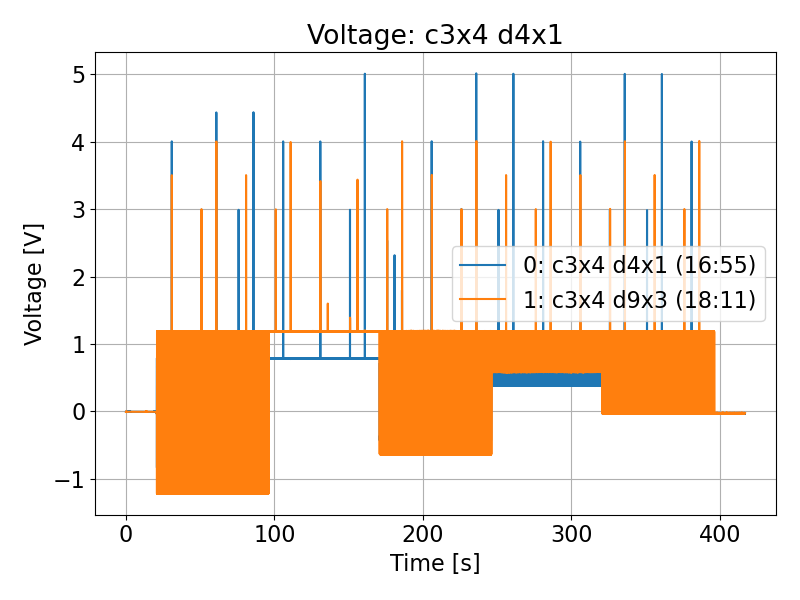

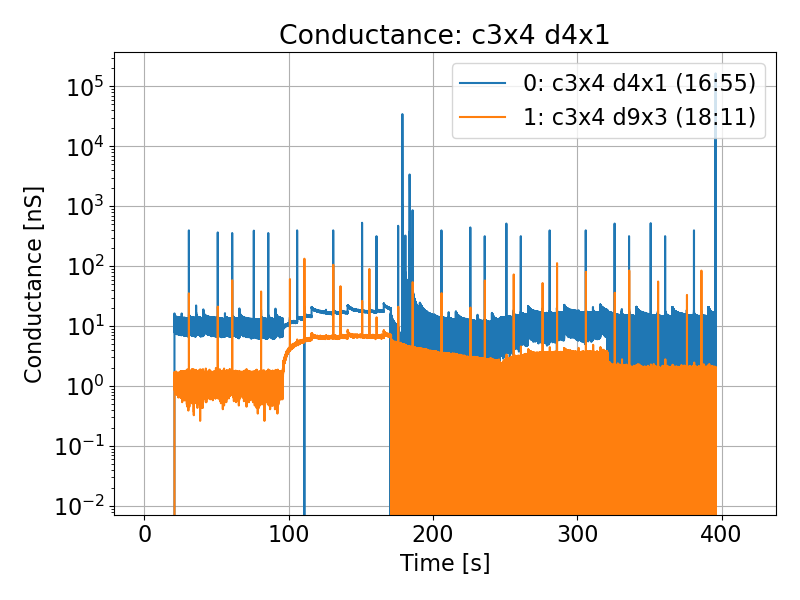

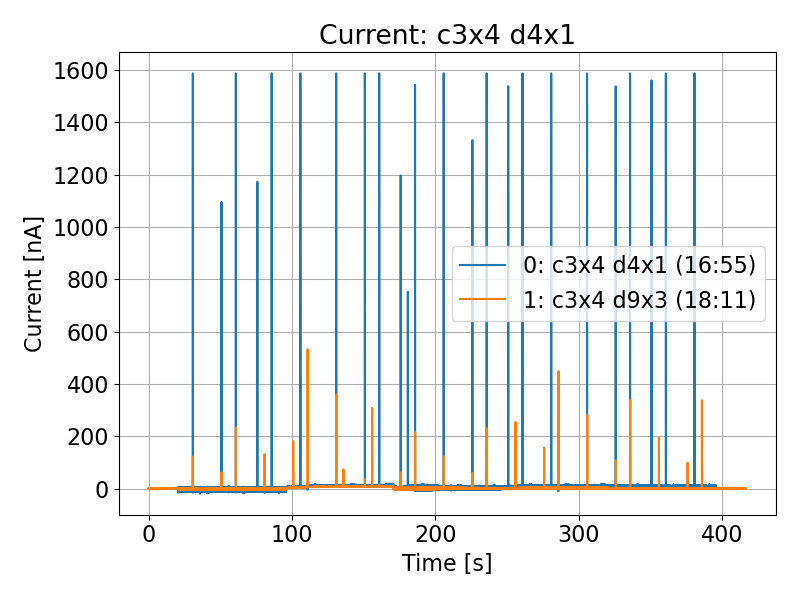

In [29]:
plt.close('all')

figures = []
figure_names = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for spec in figure_specs:
        figsize_labelled = list(figsize)
        figsize_labelled[0] = figsize[0] * (1+figsize_factor*int(legend_pos == 'outside'))
        if spec['no_labels']:
            fig, axs = plt.subplots(1,1, figsize=figsize)
        else:
            fig, axs = plt.subplots(1,1, figsize=figsize_labelled)
        
        for i, idx in enumerate(plot_selection):
            m = an.measurements[idx]
            data = m['data'].iloc[::interleave]      
            x = data[spec['x_axis']]
            y = data[spec['y_axis']]
            if 'abs' in spec and spec['abs']:
                y = y.abs()
            if spec['xlim'].size:
                mask = (x >= spec['xlim'][0]) & (x <= spec['xlim'][1])
                x = x[mask]
                y = y[mask]
    
            color = color_map(cmap, i)
            if max_legend_entries is None or i < max_legend_entries:
                label = _parse_template(m, spec['legend_template'])
            else:
                label = '_no_label_'
            y_factor = spec['yfactor']
            axs.plot(x, y*y_factor, color=color, linestyle=linestyle_map[i], label=label);


        axs.set_xscale(spec['xscale'])
        axs.set_yscale(spec['yscale'])

        if spec['xlim'].size:
            axs.set_xlim(tuple(spec['xlim']))
        if spec['ylim'].size:
            axs.set_ylim(tuple(spec['ylim'] * y_factor))


        name = _parse_template(an.measurements[plot_selection[0]], spec['title'])
        figure_names.append(name)
        if not spec['no_labels']:
            legend_kwargs = {}
            if legend_pos == 'outside':
                legend_kwargs['bbox_to_anchor'] = (1,1)
                legend_kwargs['loc'] = 'upper left'
            else:
                legend_kwargs['loc'] = legend_pos
            
            if legend_labels:
                axs.legend(legend_labels, **legend_kwargs)
            else:
                axs.legend(**legend_kwargs)
                
            axs.set_xlabel(spec['x_axis'] + ' ' + units[spec['x_axis']])
            axs.set_ylabel(spec['y_axis'] + ' ' + units[spec['y_axis']])
            axs.set_title(name)
            axs.grid()

        
       
        
        fig.tight_layout()
        figures.append(fig)

### Save figures 

In [38]:
savenames = figure_names
subdirectory = 'clean'
save_figures(figures, figure_specs, savenames, directory, subdirectory=subdirectory, filetype='pdf')

/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Voltage_c3x4_d4x1
Should file be overwritten: yes[y] / no [n] / no to all [nn] / yes to all [yy] / rename [r] / rename all [rr]:
Not saving any measurements
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Conductance_c3x4_d4x1_ylog
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Current_c3x4_d4x1


# Split Selection 

In [85]:
# Get timestamps at the falling edge of the voltage pulses > 1.2V
selection = selection_to_manipulate
an.set_selection(selection)

split_timestamps = an.pick_timestamps_trigger('Voltage', 1.2, timestamp_offset=-4e-3, n_points_before_pulse_end=0, n_points_per_pulse=1, active_edge='falling')
#print(split_timestamps)


In [86]:
# Add timestamps manually (for example the time of the falling edge of the UV pulse)

idces_to_mod = selection_to_manipulate
t_stamps = {k:v for k,v in split_timestamps.items() if k in idces_to_mod}

t_stamps_mod = {k:[] for k in idces_to_mod}

for idx, stamps in t_stamps.items():
    for i, stamp in enumerate(stamps):
        t_stamps_mod[idx].append(stamp)
        if (i+1)%3 == 0:
            t_stamps_mod[idx].append(stamp+5.001)
   
# display(t_stamps_mod)



In [87]:
# Split selection

if not 'split_selections' in an.manipulated_selections:
    an.manipulated_selections['split_selections'] = {}
    
skip_known = False

In [88]:
split_points = split_timestamps
split_points = t_stamps_mod

col = 'Time'

add_labels = {}

overlap = 0
split_on_change = False
start_value = 0

if split_on_change:
    assert col != 'Time'

for sel,s in split_points.items():
    if skip_known and (sel in an.manipulated_selections['split_selections']):
        continue
    an.set_selection([sel])
    selection_split = an.split_selection(col, split_points, overlap=overlap, start_value=start_value, add_labels=add_labels)
    an.manipulated_selections['split_selections'][sel] = selection_split
    
#display(selection_split)

In [89]:
# Add custom attributes
attributes = {}

V_biases = [-0.8]*13 + [0.8]*12 + [-0.4]*12 + [0.4]*12 + [0]*12
V_pulses = [0.8] + [3, 4, 5, 'UV']*3*5

attributes[0] = {
    'V_bias': V_biases,
    'V_pulse': V_pulses
}

V_biases = [-1.2]*13 + [1.2]*12 + [-0.6]*12 + [0.6]*12 + [0]*12
V_pulses = [1.2] + [3, 4, 5, 'UV']*3*5

attributes[1] = {
    'V_bias': V_biases,
    'V_pulse': V_pulses
}

        
    

In [90]:
for idx in selection:
    split_sel = an.manipulated_selections['split_selections'][idx]
    for i, split_idx in enumerate(split_sel):
        m = an.measurements[split_idx]
        m['V_bias'] = attributes[idx]['V_bias'][i]
        m['V_pulse'] = attributes[idx]['V_pulse'][i]
        m['idx'] = split_idx

# Plot Split Measurement

In [281]:
selection = [0]

chosen_sel = 'normal'
chosen_sel = 'split_selections'

In [282]:
split_idces = list(range(1, 13)) # All pulses bias -0.8
# split_idces = list(range(13, 25)) # All pulses bias 0.8
# split_idces = list(range(25, 37)) # All pulses bias -0.4
#split_idces = list(range(37, 49)) # All pulses bias 0.4
#split_idces = list(range(49, 61)) # All pulses bias 0

plot_selection = []

for idx in selection:
    man_sel = an.manipulated_selections[chosen_sel][idx]
    if chosen_sel != 'normal':
        man_sel = [s for i,s in enumerate(man_sel) if i in split_idces]
        
    plot_selection += man_sel

In [283]:
print(plot_selection)

['0_split_1', '0_split_2', '0_split_3', '0_split_4', '0_split_5', '0_split_6', '0_split_7', '0_split_8', '0_split_9', '0_split_10', '0_split_11', '0_split_12']


### Plot Setup 

In [284]:
# Data Range
interleave = 1

xlim = [0, 0.04]

y_factor = 1e9

In [285]:
# Plot Design
figsize = (8,6)

figsize_factor = 0.5

font = {'weight' : 'normal',
        'size'   : 16}
        
plt.rc('font', **font)

cmap = plt.cm.get_cmap('tab10')
colors = plt.cm.hsv(np.linspace(0,1,4))

def color_map(cmap, i):
    # mapping = list(range(10))
    # mapping = [2, 3, 2, 3]
    mapping = [0,1,2,4,0,1,2,4,0,1,2,4]
    #mapping = None
    if mapping is None or int(i) >= len(mapping):
        return cmap(int(i)%10)
    elif type(mapping[int(i)]) is int:     
        return cmap(mapping[int(i)])
    else:
        return mapping[int(i)]

# def color_map(cmap, i):
#     return colors[i]


linestyle_map = ['-']*100
#linestyle_map = ['--', '--', '-', '-', '-', '--', '-', '--', '-', '--']

In [286]:
# Labels
no_labels = False

title_template = 'Split {cluster} {device} (V_bias = {V_bias}V)'
#title_template = 'DC'

units = {'Conductance': '[nS]', 'Time': '[s]', 'Voltage': '[V]', 'Current': '[nA]'}


legend_template = 'V_pulse = {V_pulse} ({timestamp:%H:%M})'

max_legend_entries = 4

legend_labels = []

legend_pos = 'outside'
#legend_pos = 'best'
#legend_pos = 'upper right'

In [287]:
# Figure specification
figure_specs = [
    {
        'title': 'Voltage: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Voltage',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array([]),
        'ylim': np.array([]),
        'yfactor': 1,
        'legend_template': legend_template,
        'no_labels': no_labels
    },
    {
        'title': 'Conductance: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Conductance',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'log',
        'xlim': np.array([]),
        'ylim': np.array([]), #[9e-9, 30e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels
    },
    {
        'title': 'Current: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Current',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array([]),
        'ylim': np.array([]), # [4e-9, 20e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels
    },    
    {
        'title': 'Voltage Zoom: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Voltage',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array(xlim),
        'ylim': np.array([]),
        'yfactor': 1,
        'legend_template': legend_template,
        'no_labels': no_labels
    },
    {
        'title': 'Conductance Zoom: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Conductance',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'log',
        'xlim': np.array(xlim),
        'ylim': np.array([]), #[9e-9, 30e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels
    },
    {
        'title': 'Current Zoom: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Current',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array(xlim),
        'ylim': np.array([]), # [4e-9, 20e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels
    },    
]   

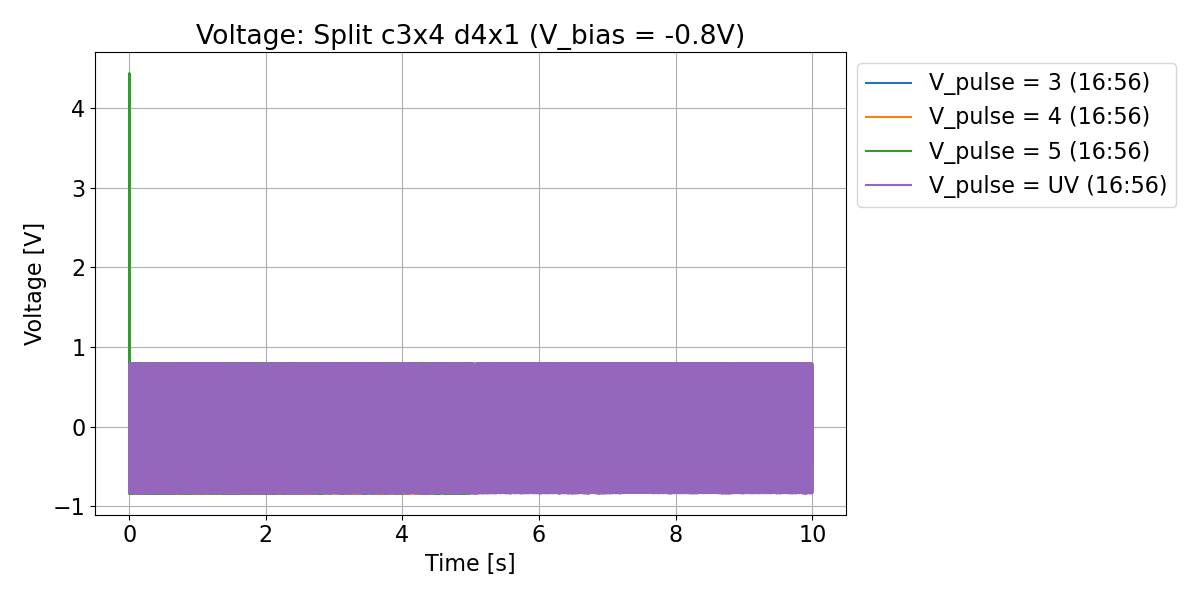

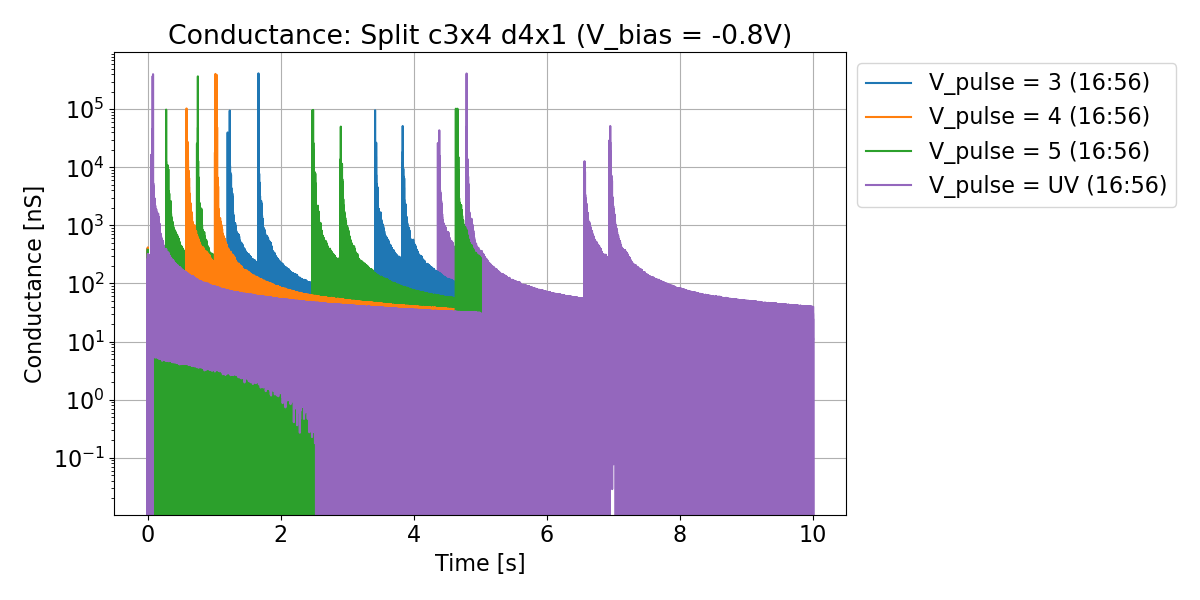

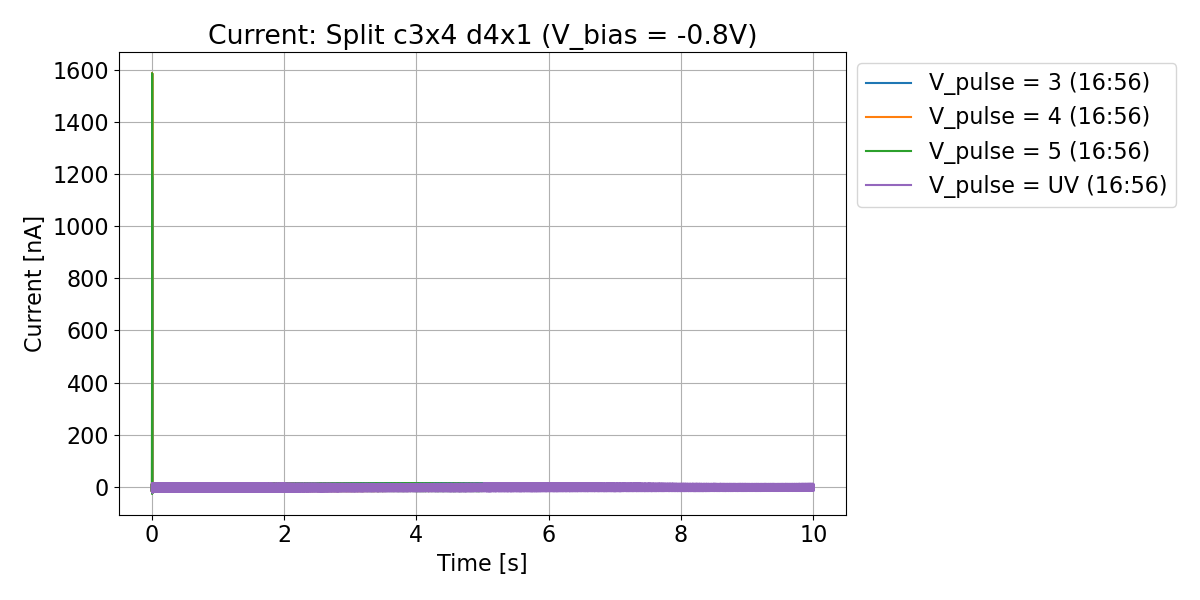

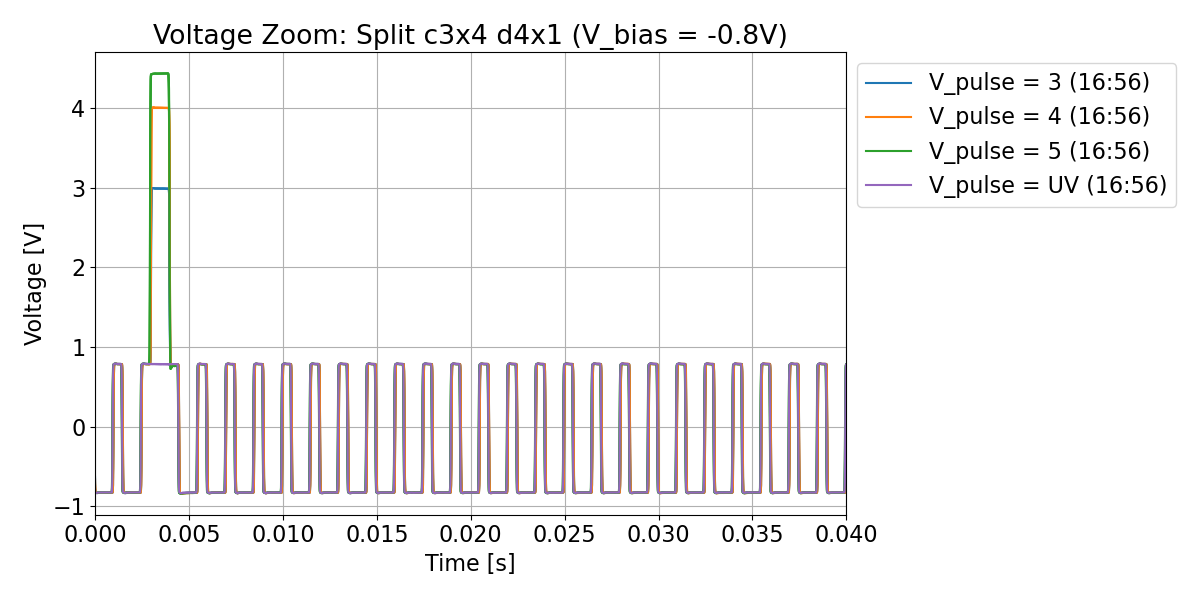

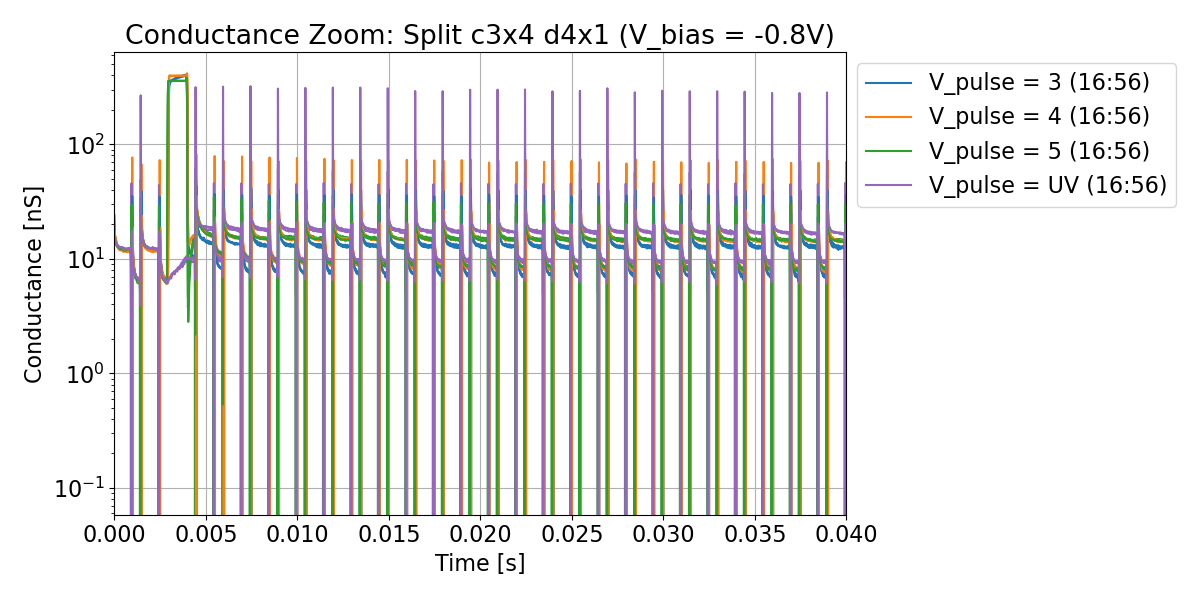

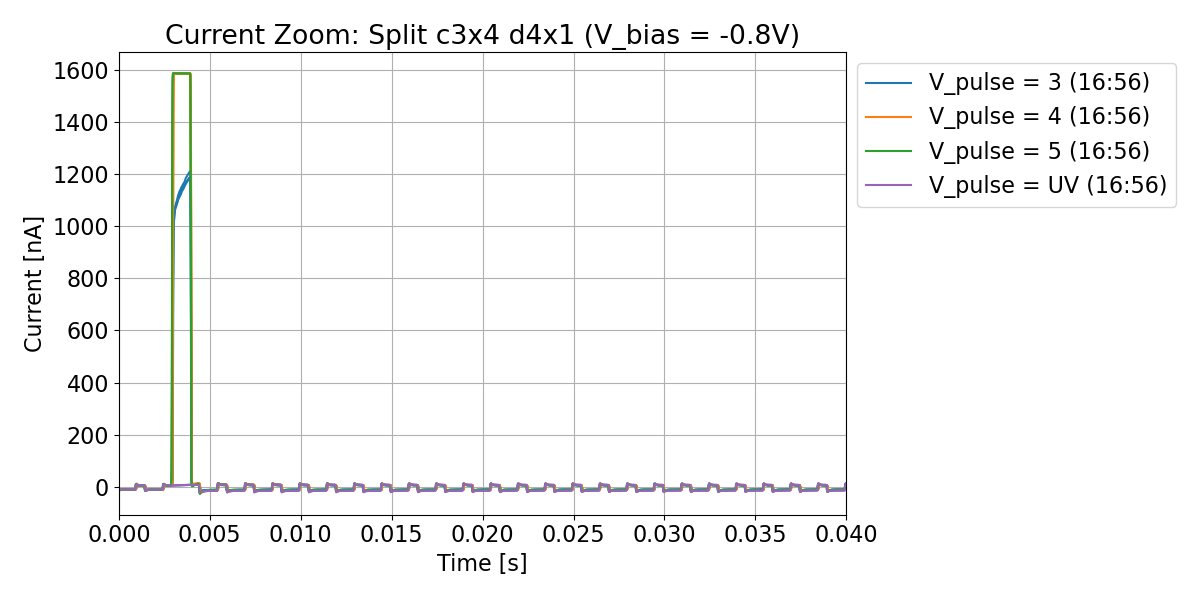

In [288]:
plt.close('all')

figures = []
figure_names = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for spec in figure_specs:
        figsize_labelled = list(figsize)
        figsize_labelled[0] = figsize[0] * (1+figsize_factor*int(legend_pos == 'outside'))
        if spec['no_labels']:
            fig, axs = plt.subplots(1,1, figsize=figsize)
        else:
            fig, axs = plt.subplots(1,1, figsize=figsize_labelled)
        
        for i, idx in enumerate(plot_selection):
            m = an.measurements[idx]
            data = m['data'].iloc[::interleave]      
            x = data[spec['x_axis']]
            y = data[spec['y_axis']]
            if 'abs' in spec and spec['abs']:
                y = y.abs()
            if spec['xlim'].size:
                mask = (x >= spec['xlim'][0]) & (x <= spec['xlim'][1])
                x = x[mask]
                y = y[mask]
    
            color = color_map(cmap, i)
            if max_legend_entries is None or i < max_legend_entries:
                label = _parse_template(m, spec['legend_template'])
            else:
                label = '_no_label_'
            y_factor = spec['yfactor']
            axs.plot(x, y*y_factor, color=color, linestyle=linestyle_map[i], label=label);


        axs.set_xscale(spec['xscale'])
        axs.set_yscale(spec['yscale'])

        if spec['xlim'].size:
            axs.set_xlim(tuple(spec['xlim']))
        if spec['ylim'].size:
            axs.set_ylim(tuple(spec['ylim'] * y_factor))


        name = _parse_template(an.measurements[plot_selection[0]], spec['title'])
        figure_names.append(name)
        if not spec['no_labels']:
            legend_kwargs = {}
            if legend_pos == 'outside':
                legend_kwargs['bbox_to_anchor'] = (1,1)
                legend_kwargs['loc'] = 'upper left'
            else:
                legend_kwargs['loc'] = legend_pos
            
            if legend_labels:
                axs.legend(legend_labels, **legend_kwargs)
            else:
                axs.legend(**legend_kwargs)
                
            axs.set_xlabel(spec['x_axis'] + ' ' + units[spec['x_axis']])
            axs.set_ylabel(spec['y_axis'] + ' ' + units[spec['y_axis']])
            axs.set_title(name)
            axs.grid()

        
       
        
        fig.tight_layout()
        figures.append(fig)

### Save figures 

In [94]:
savenames = figure_names
subdirectory = 'clean'
save_figures(figures, figure_specs, savenames, directory, subdirectory=subdirectory, filetype='pdf')

/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Voltage_Split_c3x4_d4x1_V_bias_=_-0_8V
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Conductance_Split_c3x4_d4x1_V_bias_=_-0_8V_ylog
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Current_Split_c3x4_d4x1_V_bias_=_-0_8V
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Voltage_Zoom_Split_c3x4_d4x1_V_bias_=_-0_8V_x=0E+00_to_4E-02
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Conductance_Zoom_Split_c3x4_d4x1_V_bias_=_-0_8V_ylog_x=0E+00_to_4E-02
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short

# Manipulate Split Selection

In [91]:
selection = selection_to_manipulate
#selection = [42]


### Pick Points Trigger

In [92]:
sel = selection
act_on_selections = 'split_selections'
#act_on_selections = 'normal'

In [93]:
if not 'triggered_selections' in an.manipulated_selections:
    an.manipulated_selections['triggered_selections'] = {}
    
skip_known = False

In [94]:
#tr_level = 0.78
tr_level = {0:0.78, 1:1.18}

n_points_per_pulse = 1
n_points_before_pulse_end = 2
active_edge = 'falling'
fill_above_trigger_level_points = 100

In [95]:
triggered_selections = {}
for s in sel:
    if skip_known and (s in an.manipulated_selections['triggered_selections']):
        continue
    
    act_sel = an.manipulated_selections[act_on_selections][s]
    try:
        trigger_level = tr_level[s]
    except Exception:
        an.manipulated_selections['triggered_selections'][s] = act_sel
        continue

    an.set_selection(act_sel)
    an.manipulated_selections['triggered_selections'][s] = an.pick_points_trigger(trigger_level, n_points_per_pulse=n_points_per_pulse, n_points_before_pulse_end=n_points_before_pulse_end, 
                                                                                  active_edge=active_edge, fill_above_trigger_level_points=fill_above_trigger_level_points)
    


In [96]:
print(an.manipulated_selections['triggered_selections'])

{0: ['0_split_0_trig', '0_split_1_trig', '0_split_2_trig', '0_split_3_trig', '0_split_4_trig', '0_split_5_trig', '0_split_6_trig', '0_split_7_trig', '0_split_8_trig', '0_split_9_trig', '0_split_10_trig', '0_split_11_trig', '0_split_12_trig', '0_split_13_trig', '0_split_14_trig', '0_split_15_trig', '0_split_16_trig', '0_split_17_trig', '0_split_18_trig', '0_split_19_trig', '0_split_20_trig', '0_split_21_trig', '0_split_22_trig', '0_split_23_trig', '0_split_24_trig', '0_split_25_trig', '0_split_26_trig', '0_split_27_trig', '0_split_28_trig', '0_split_29_trig', '0_split_30_trig', '0_split_31_trig', '0_split_32_trig', '0_split_33_trig', '0_split_34_trig', '0_split_35_trig', '0_split_36_trig', '0_split_37_trig', '0_split_38_trig', '0_split_39_trig', '0_split_40_trig', '0_split_41_trig', '0_split_42_trig', '0_split_43_trig', '0_split_44_trig', '0_split_45_trig', '0_split_46_trig', '0_split_47_trig', '0_split_48_trig', '0_split_49_trig', '0_split_50_trig', '0_split_51_trig', '0_split_52_trig'

### Moving Average

In [100]:
sel = selection
act_on_selections = 'triggered_selections'

In [101]:
if not 'mov_avg_selections' in an.manipulated_selections:
    an.manipulated_selections['mov_avg_selections'] = {}
    
skip_known = False

In [102]:
window = 10

mov_avg_selections = {}
for s in sel:
    if skip_known and (s in an.manipulated_selections['mov_avg_selections']):
        continue
     
    act_sel = an.manipulated_selections[act_on_selections][s]

    an.set_selection(act_sel)
    an.manipulated_selections['mov_avg_selections'][s] = an.moving_avg(['Conductance', 'Current'], window=window)

#print(mov_avg_selections)


### Scale Selection 

In [103]:
sel = selection
act_on_selections = 'triggered_selections'
#act_on_selections = 'mov_avg_selections'
#act_on_selections = 'cut_selections'

In [104]:
if not 'scaled_selections' in an.manipulated_selections:
    an.manipulated_selections['scaled_selections'] = {}
    
skip_known = False
scale_method = 'add'
set_G = 10e-9

In [105]:
scaled_selections = {}
for s in sel:
    if skip_known and (s in an.manipulated_selections['scaled_selections']):
        continue
        
    act_sel = an.manipulated_selections[act_on_selections][s]

    an.set_selection(act_sel)
    an.manipulated_selections['scaled_selections'][s] = an.scale_selection('Time', 'Conductance', [0, 1.5e-3], scale_method=scale_method, set_G=set_G)

#print(scaled_selections)


# Inspect Read Extraction

In [152]:
selection = selection
selection = [0]

chosen_sel_1 = 'split_selections'
#chosen_sel_1 = 'mov_avg_selections'
chosen_sel_2 = 'triggered_selections'

In [153]:
choose_split = True
split_idces = [1]

# split_idces = list(range(1, 13)) # All pulses bias -0.8
# split_idces = list(range(13, 25)) # All pulses bias 0.8
# split_idces = list(range(25, 37)) # All pulses bias -0.4
# split_idces = list(range(37, 49)) # All pulses bias 0.4
# split_idces = list(range(49, 61)) # All pulses bias 0

plot_selection = []

for idx in selection:
    man_sel = an.manipulated_selections[chosen_sel_1][idx]
    if choose_split:
        man_sel = [s for i,s in enumerate(man_sel) if i in split_idces]
        
    plot_selection += man_sel

for idx in selection:
    man_sel = an.manipulated_selections[chosen_sel_2][idx]
    if choose_split:
        man_sel = [s for i,s in enumerate(man_sel) if i in split_idces]
        
    plot_selection += man_sel

In [154]:
print(plot_selection)

['0_split_1_trig_m_avg', '0_split_1_trig']


### Plot Setup 

In [155]:
# Data Range
interleave = 1

xlim = [0, 0.04]

y_factor = 1e9

In [156]:
# Plot Design
figsize = (8,6)

figsize_factor = 0.5

font = {'weight' : 'normal',
        'size'   : 16}
        
plt.rc('font', **font)

cmap = plt.cm.get_cmap('tab10')
def color_map(cmap, i):
    # mapping = list(range(10))
    # mapping = [2, 3, 2, 3]
    mapping = [0,1,2,4,0,1,2,4,0,1,2,4]
    #mapping = None
    if mapping is None or int(i) >= len(mapping):
        return cmap(int(i)%10)
    elif type(mapping[int(i)]) is int:     
        return cmap(mapping[int(i)])
    else:
        return mapping[int(i)]

# def color_map(cmap, i):
#     return colors[i]


linestyle_map = ['-']*100
#linestyle_map = ['--', '--', '-', '-', '-', '--', '-', '--', '-', '--']

grid = True

In [157]:
# Labels
no_labels = False

title_template = 'Split only Read {cluster} {device} (V_bias = {V_bias}V)'
#title_template = 'DC'

units = {'Conductance': '[nS]', 'Time': '[s]', 'Voltage': '[V]', 'Current': '[nA]'}


legend_template = '{idx}'

legend_labels = []

max_legend_entries = 4

legend_pos = 'outside'
#legend_pos = 'best'
legend_pos = 'upper right'


In [158]:
# Figure specification
figure_specs = [
    {
        'title': 'Voltage: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Voltage',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array([]),
        'ylim': np.array([]),
        'yfactor': 1,
        'legend_template': legend_template,
        'no_labels': no_labels
    },
    {
        'title': 'Conductance: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Conductance',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'log',
        'xlim': np.array([]),
        'ylim': np.array([]), #[9e-9, 30e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels
    },
    {
        'title': 'Current: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Current',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array([]),
        'ylim': np.array([]), # [4e-9, 20e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels
    },    
    {
        'title': 'Voltage Zoom: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Voltage',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array(xlim),
        'ylim': np.array([]),
        'yfactor': 1,
        'legend_template': legend_template,
        'no_labels': no_labels,
        'plt_kwargs': {'marker':'o', 'markersize':4}
    },
    {
        'title': 'Conductance Zoom: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Conductance',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'log',
        'xlim': np.array(xlim),
        'ylim': np.array([]), #[9e-9, 30e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels,
        'markers': True,
        'plt_kwargs': {'marker':'o', 'markersize':4}
    },
    {
        'title': 'Current Zoom: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Current',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array(xlim),
        'ylim': np.array([]), # [4e-9, 20e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels,
        'markers': True,
        'plt_kwargs': {'marker':'o', 'markersize':4}
    },    
]   

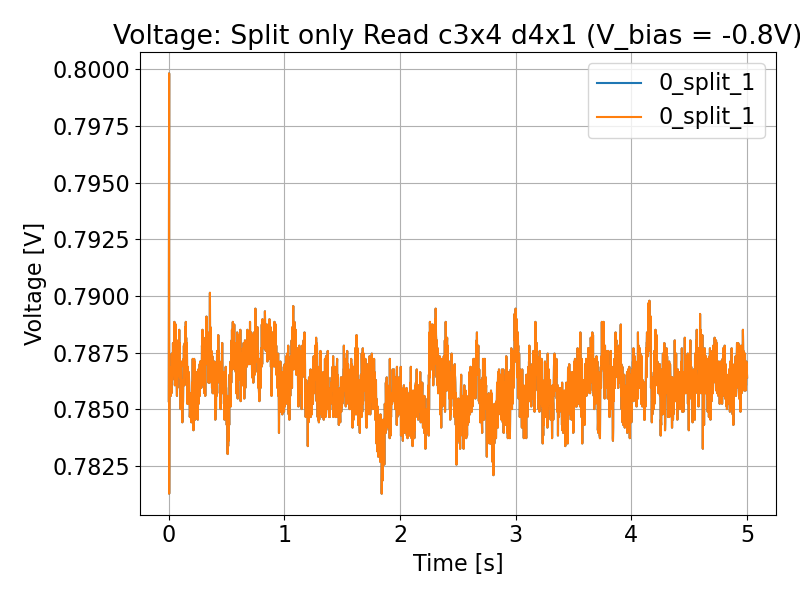

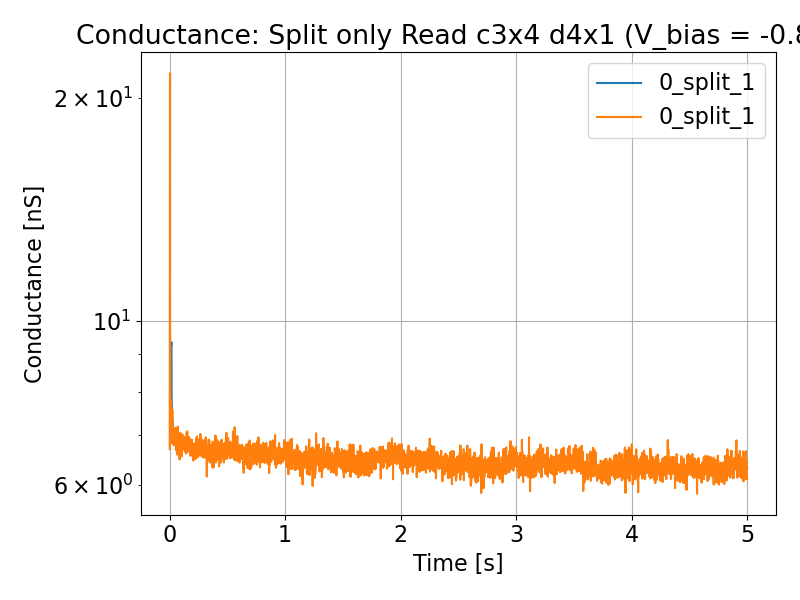

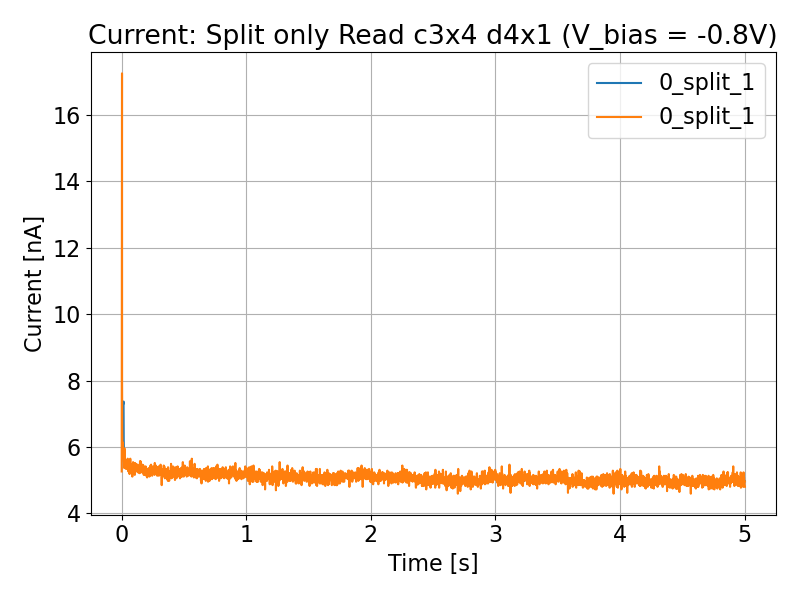

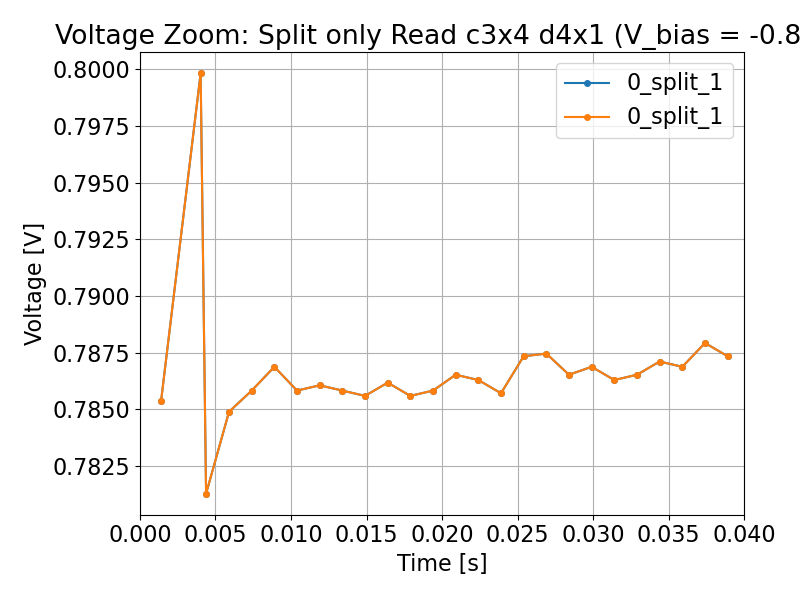

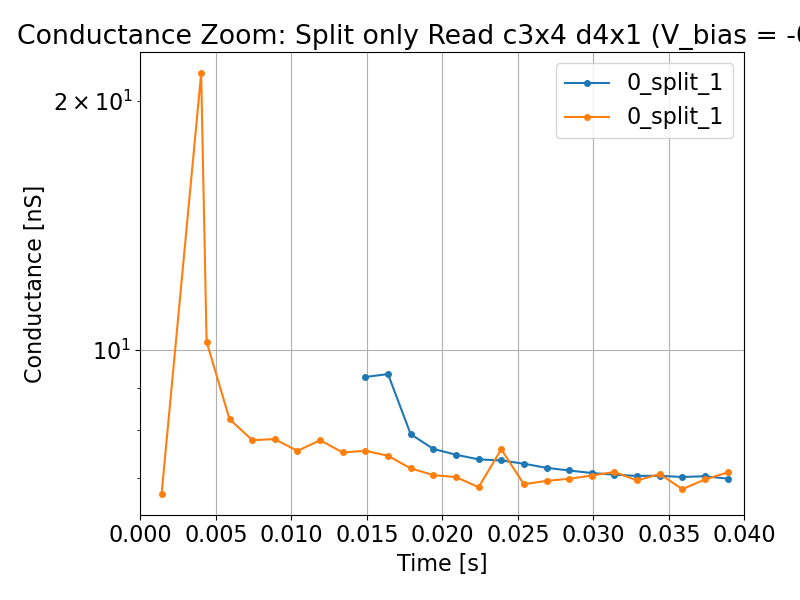

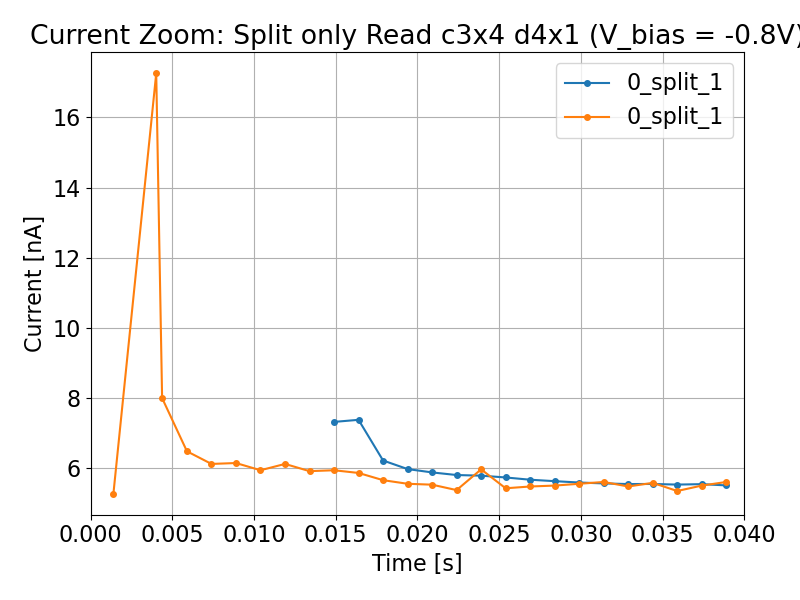

In [159]:
plt.close('all')

figures = []
figure_names = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for spec in figure_specs:
        figsize_labelled = list(figsize)
        figsize_labelled[0] = figsize[0] * (1+figsize_factor*int(legend_pos == 'outside'))
        if spec['no_labels']:
            fig, axs = plt.subplots(1,1, figsize=figsize)
        else:
            fig, axs = plt.subplots(1,1, figsize=figsize_labelled)
        
        for i, idx in enumerate(plot_selection):
            m = an.measurements[idx]
            data = m['data'].iloc[::interleave]      
            x = data[spec['x_axis']]
            y = data[spec['y_axis']]
            if 'abs' in spec and spec['abs']:
                y = y.abs()
            if spec['xlim'].size:
                mask = (x >= spec['xlim'][0]) & (x <= spec['xlim'][1])
                x = x[mask]
                y = y[mask]

            y_factor = spec['yfactor']

            color = color_map(cmap, i)

            if max_legend_entries is None or i < max_legend_entries:
                label = _parse_template(m, spec['legend_template'])
            else:
                label = '_no_label_'

            if 'plt_kwargs' in spec and spec['plt_kwargs']:
                plt_kwargs = spec['plt_kwargs']
            else:
                plt_kwargs = {}
            
            axs.plot(x, y*y_factor, color=color, linestyle=linestyle_map[i], label=label, **plt_kwargs);


        axs.set_xscale(spec['xscale'])
        axs.set_yscale(spec['yscale'])

        if spec['xlim'].size:
            axs.set_xlim(tuple(spec['xlim']))
        if spec['ylim'].size:
            axs.set_ylim(tuple(spec['ylim'] * y_factor))


        name = _parse_template(an.measurements[plot_selection[0]], spec['title'])
        figure_names.append(name)
        if not spec['no_labels']:
            legend_kwargs = {}
            if legend_pos == 'outside':
                legend_kwargs['bbox_to_anchor'] = (1,1)
                legend_kwargs['loc'] = 'upper left'
            else:
                legend_kwargs['loc'] = legend_pos
            
            if legend_labels:
                axs.legend(legend_labels, **legend_kwargs)
            else:
                axs.legend(**legend_kwargs)
                
            axs.set_xlabel(spec['x_axis'] + ' ' + units[spec['x_axis']])
            axs.set_ylabel(spec['y_axis'] + ' ' + units[spec['y_axis']])
            axs.set_title(name)
            if grid:
                axs.grid()

        
       
        
        fig.tight_layout()
        figures.append(fig)

### Save figures 

In [ ]:
savenames = figure_names
subdirectory = 'clean'
save_figures(figures, figure_specs, savenames, directory, subdirectory=subdirectory, filetype='pdf')

/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Voltage_Split_only_Read_c3x4_d4x1_V_bias_=_0_8V
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Conductance_Split_only_Read_c3x4_d4x1_V_bias_=_0_8V_ylog
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Current_Split_only_Read_c3x4_d4x1_V_bias_=_0_8V
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Voltage_Zoom_Split_only_Read_c3x4_d4x1_V_bias_=_0_8V_x=0E+00_to_4E-02
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Conductance_Zoom_Split_only_Read_c3x4_d4x1_V_bias_=_0_8V_ylog_x=0E+00_to_4E-02
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-

# Plot same bias only during Read

In [160]:
selection = selection
selection = [0]

chosen_sel = 'normal'
chosen_sel = 'split_selections'
chosen_sel = 'triggered_selections'
#chosen_sel = 'mov_avg_selections'

In [161]:
choose_split = True
split_idces = list(range(1, 13)) # All pulses bias -0.8
# split_idces = list(range(13, 25)) # All pulses bias 0.8
# split_idces = list(range(25, 37)) # All pulses bias -0.4
# split_idces = list(range(37, 49)) # All pulses bias 0.4
# split_idces = list(range(49, 61)) # All pulses bias 0

plot_selection = []

for idx in selection:
    man_sel = an.manipulated_selections[chosen_sel][idx]
    if choose_split:
        man_sel = [s for i,s in enumerate(man_sel) if i in split_idces]
        
    plot_selection += man_sel

In [162]:
print(plot_selection)

['0_split_1_trig_m_avg', '0_split_2_trig_m_avg', '0_split_3_trig_m_avg', '0_split_4_trig_m_avg', '0_split_5_trig_m_avg', '0_split_6_trig_m_avg', '0_split_7_trig_m_avg', '0_split_8_trig_m_avg', '0_split_9_trig_m_avg', '0_split_10_trig_m_avg', '0_split_11_trig_m_avg', '0_split_12_trig_m_avg']


### Plot Setup 

In [163]:
# Data Range
interleave = 1

xlim = [0, 0.04]

y_factor = 1e9

In [164]:
# Plot Design
figsize = (8,6)

figsize_factor = 0.5

font = {'weight' : 'normal',
        'size'   : 16}
        
plt.rc('font', **font)

cmap = plt.cm.get_cmap('tab10')
colors = plt.cm.hsv(np.linspace(0,1,4))

def color_map(cmap, i):
    # mapping = list(range(10))
    # mapping = [2, 3, 2, 3]
    mapping = [0,1,2,4,0,1,2,4,0,1,2,4]
    #mapping = None
    if mapping is None or int(i) >= len(mapping):
        return cmap(int(i)%10)
    elif type(mapping[int(i)]) is int:     
        return cmap(mapping[int(i)])
    else:
        return mapping[int(i)]

# def color_map(cmap, i):
#     return colors[i]


linestyle_map = ['-']*100
#linestyle_map = ['--', '--', '-', '-', '-', '--', '-', '--', '-', '--']

In [165]:
# Labels
no_labels = False

title_template = 'Split only Read {cluster} {device} (V_bias = {V_bias}V)'
#title_template = 'DC'

units = {'Conductance': '[nS]', 'Time': '[s]', 'Voltage': '[V]', 'Current': '[nA]'}


legend_template = 'V_pulse = {V_pulse}V ({timestamp:%H:%M})'

legend_labels = []

max_legend_entries = 4

legend_pos = 'outside'
#legend_pos = 'best'
#legend_pos = 'upper right'


In [166]:
# Figure specification
figure_specs = [
    {
        'title': 'Voltage: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Voltage',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array([]),
        'ylim': np.array([]),
        'yfactor': 1,
        'legend_template': legend_template,
        'no_labels': no_labels
    },
    {
        'title': 'Conductance: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Conductance',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'log',
        'xlim': np.array([]),
        'ylim': np.array([]), #[9e-9, 30e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels
    },
    {
        'title': 'Current: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Current',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array([]),
        'ylim': np.array([]), # [4e-9, 20e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels
    },    
    {
        'title': 'Voltage Zoom: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Voltage',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array(xlim),
        'ylim': np.array([]),
        'yfactor': 1,
        'legend_template': legend_template,
        'no_labels': no_labels
    },
    {
        'title': 'Conductance Zoom: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Conductance',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'log',
        'xlim': np.array(xlim),
        'ylim': np.array([]), #[9e-9, 30e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels
    },
    {
        'title': 'Current Zoom: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Current',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array(xlim),
        'ylim': np.array([]), # [4e-9, 20e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels
    },    
]   

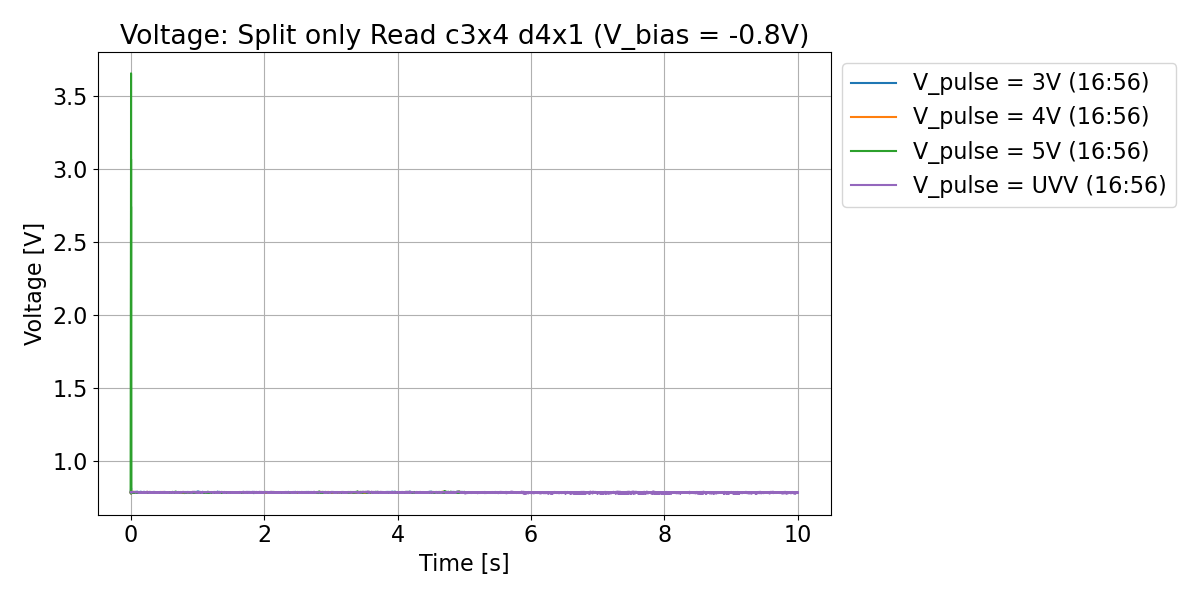

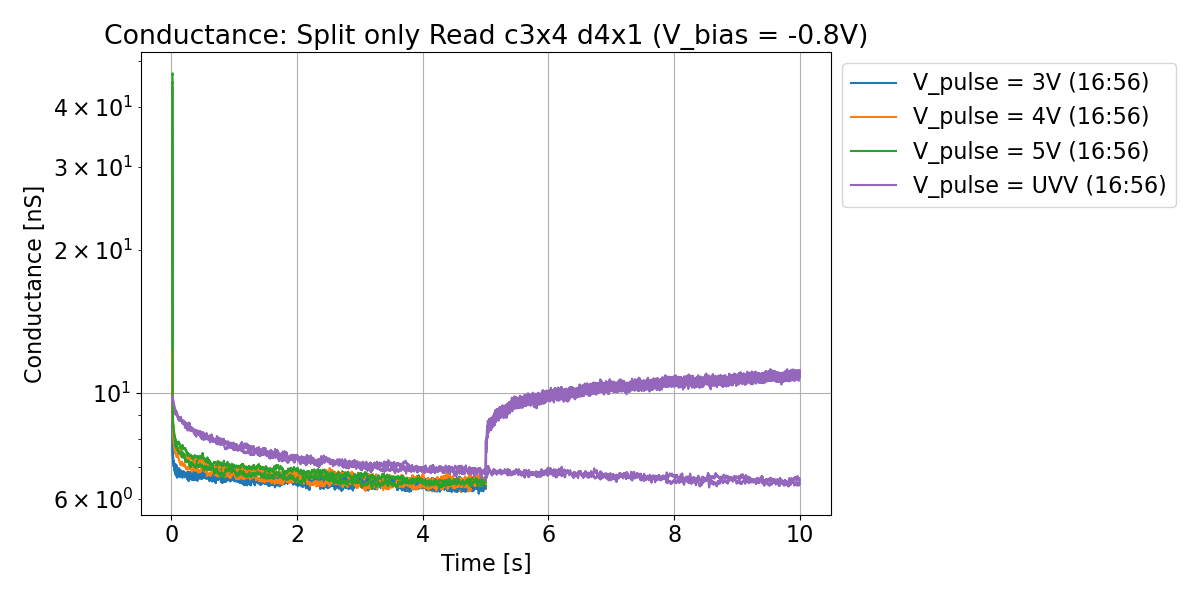

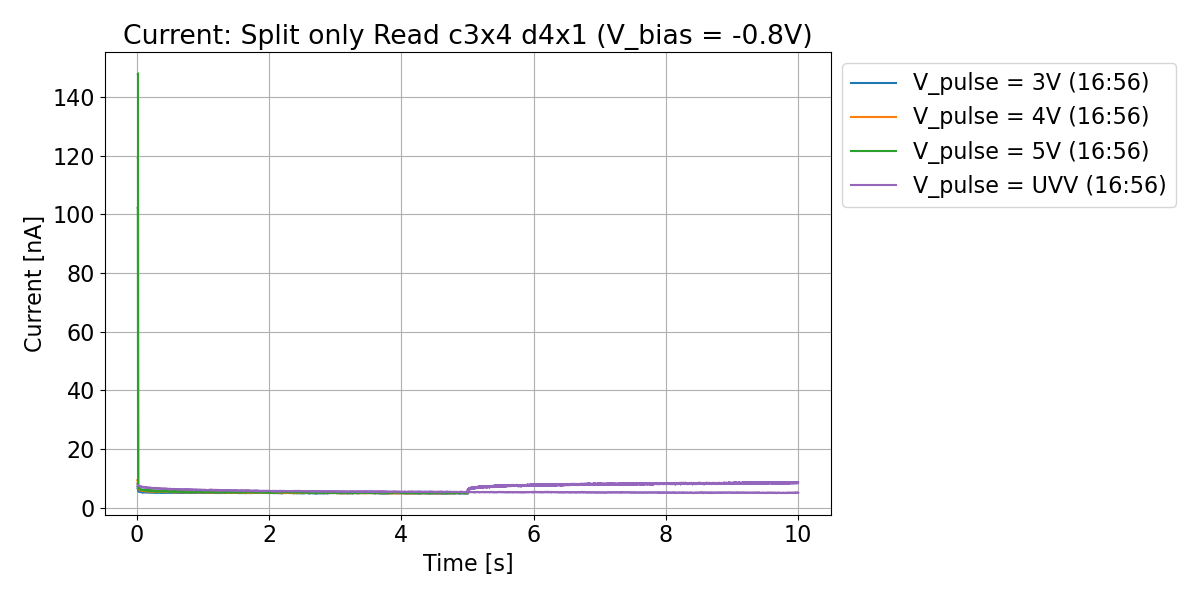

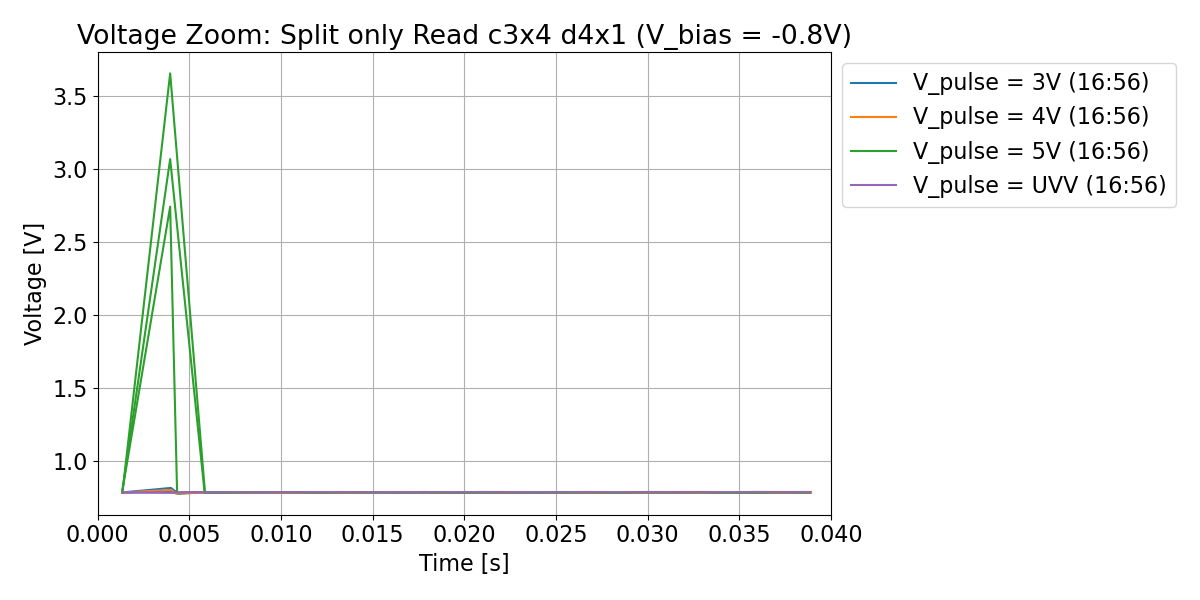

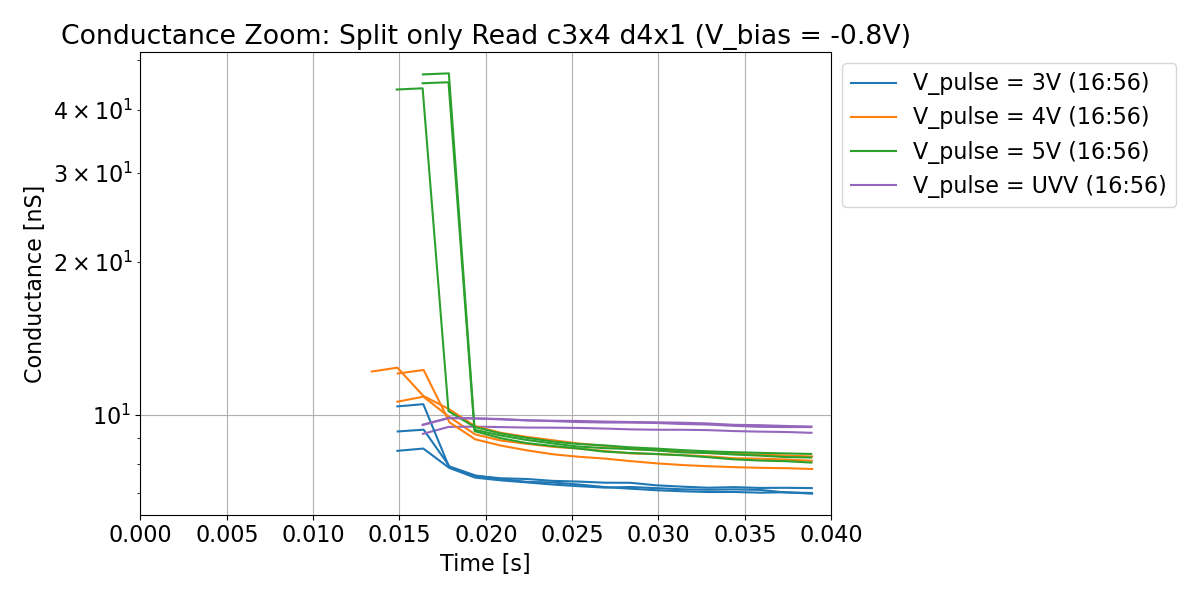

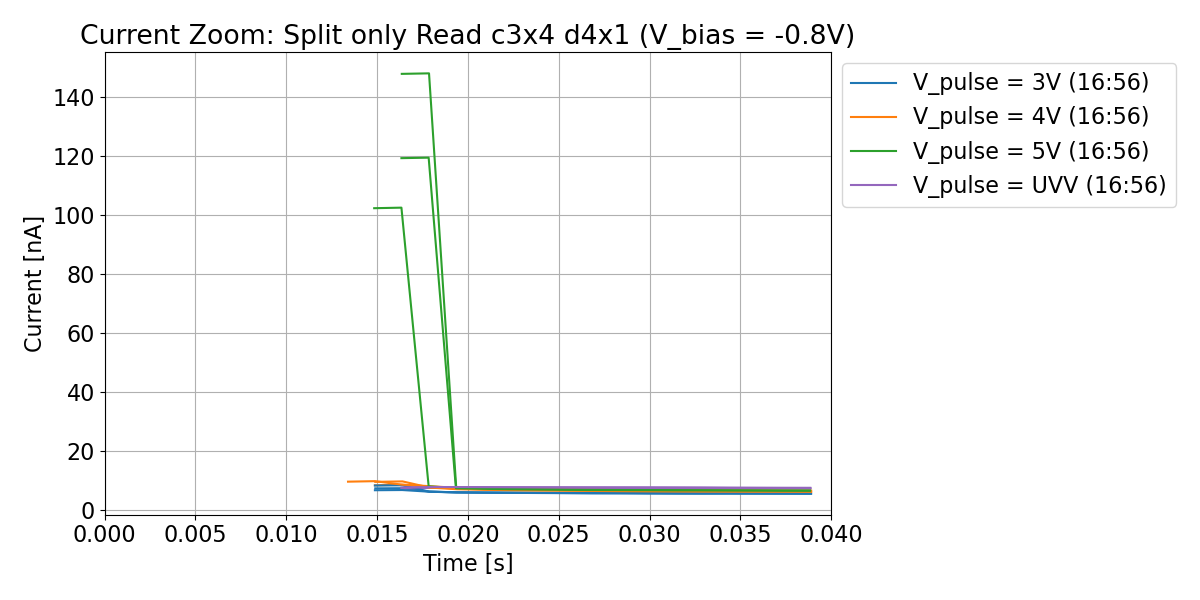

In [167]:
plt.close('all')

figures = []
figure_names = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for spec in figure_specs:
        figsize_labelled = list(figsize)
        figsize_labelled[0] = figsize[0] * (1+figsize_factor*int(legend_pos == 'outside'))
        if spec['no_labels']:
            fig, axs = plt.subplots(1,1, figsize=figsize)
        else:
            fig, axs = plt.subplots(1,1, figsize=figsize_labelled)
        
        for i, idx in enumerate(plot_selection):
            m = an.measurements[idx]
            data = m['data'].iloc[::interleave]      
            x = data[spec['x_axis']]
            y = data[spec['y_axis']]
            if 'abs' in spec and spec['abs']:
                y = y.abs()
            if spec['xlim'].size:
                mask = (x >= spec['xlim'][0]) & (x <= spec['xlim'][1])
                x = x[mask]
                y = y[mask]
    
            color = color_map(cmap, i)
            if max_legend_entries is None or i < max_legend_entries:
                label = _parse_template(m, spec['legend_template'])
            else:
                label = '_no_label_'
            y_factor = spec['yfactor']
            axs.plot(x, y*y_factor, color=color, linestyle=linestyle_map[i], label=label);


        axs.set_xscale(spec['xscale'])
        axs.set_yscale(spec['yscale'])

        if spec['xlim'].size:
            axs.set_xlim(tuple(spec['xlim']))
        if spec['ylim'].size:
            axs.set_ylim(tuple(spec['ylim'] * y_factor))


        name = _parse_template(an.measurements[plot_selection[0]], spec['title'])
        figure_names.append(name)
        if not spec['no_labels']:
            legend_kwargs = {}
            if legend_pos == 'outside':
                legend_kwargs['bbox_to_anchor'] = (1,1)
                legend_kwargs['loc'] = 'upper left'
            else:
                legend_kwargs['loc'] = legend_pos
            
            if legend_labels:
                axs.legend(legend_labels, **legend_kwargs)
            else:
                axs.legend(**legend_kwargs)
                
            axs.set_xlabel(spec['x_axis'] + ' ' + units[spec['x_axis']])
            axs.set_ylabel(spec['y_axis'] + ' ' + units[spec['y_axis']])
            axs.set_title(name)
            axs.grid()

        
       
        
        fig.tight_layout()
        figures.append(fig)

### Save figures 

In [182]:
savenames = figure_names
subdirectory = 'clean'
save_figures(figures, figure_specs, savenames, directory, subdirectory=subdirectory, filetype='pdf')

/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Voltage_Split_only_Read_c3x4_d4x1_V_bias_=_0_8V
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Conductance_Split_only_Read_c3x4_d4x1_V_bias_=_0_8V_ylog
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Current_Split_only_Read_c3x4_d4x1_V_bias_=_0_8V
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Voltage_Zoom_Split_only_Read_c3x4_d4x1_V_bias_=_0_8V_x=0E+00_to_4E-02
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Conductance_Zoom_Split_only_Read_c3x4_d4x1_V_bias_=_0_8V_ylog_x=0E+00_to_4E-02
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-

# Plot same bias only during Read and scaled

In [323]:
selection = selection
selection = [0]

chosen_sel = 'normal'
chosen_sel = 'split_selections'
chosen_sel = 'triggered_selections'
chosen_sel = 'scaled_selections'
#chosen_sel = 'mov_avg_selections'

In [324]:
choose_split = True
split_idces = list(range(1, 13)) # All pulses bias -0.8
# split_idces = list(range(13, 25)) # All pulses bias 0.8
# split_idces = list(range(25, 37)) # All pulses bias -0.4
# split_idces = list(range(37, 49)) # All pulses bias 0.4
# split_idces = list(range(49, 61)) # All pulses bias 0

plot_selection = []

for idx in selection:
    man_sel = an.manipulated_selections[chosen_sel][idx]
    if choose_split:
        man_sel = [s for i,s in enumerate(man_sel) if i in split_idces]
        
    plot_selection += man_sel

In [325]:
print(plot_selection)

['0_split_1_trig_scaled', '0_split_2_trig_scaled', '0_split_3_trig_scaled', '0_split_4_trig_scaled', '0_split_5_trig_scaled', '0_split_6_trig_scaled', '0_split_7_trig_scaled', '0_split_8_trig_scaled', '0_split_9_trig_scaled', '0_split_10_trig_scaled', '0_split_11_trig_scaled', '0_split_12_trig_scaled']


### Plot Setup 

In [326]:
# Data Range
interleave = 1

xlim = [0, 0.04]

y_factor = 1e9

In [327]:
# Plot Design
figsize = (8,6)

figsize_factor = 0.5

font = {'weight' : 'normal',
        'size'   : 16}
        
plt.rc('font', **font)

cmap = plt.cm.get_cmap('tab10')
colors = plt.cm.hsv(np.linspace(0,1,4))

def color_map(cmap, i):
    # mapping = list(range(10))
    # mapping = [2, 3, 2, 3]
    mapping = [0,1,2,4,0,1,2,4,0,1,2,4]
    #mapping = None
    if mapping is None or int(i) >= len(mapping):
        return cmap(int(i)%10)
    elif type(mapping[int(i)]) is int:     
        return cmap(mapping[int(i)])
    else:
        return mapping[int(i)]

# def color_map(cmap, i):
#     return colors[i]


linestyle_map = ['-']*100
#linestyle_map = ['--', '--', '-', '-', '-', '--', '-', '--', '-', '--']

In [128]:
# Labels
no_labels = False

title_template = 'Split only Read, scaled {cluster} {device} (V_bias = {V_bias}V)'
#title_template = 'DC'

units = {'Conductance': '[nS]', 'Time': '[s]', 'Voltage': '[V]', 'Current': '[nA]'}


legend_template = 'V_pulse = {V_pulse}V ({timestamp:%H:%M})'

legend_labels = []

max_legend_entries = 4

legend_pos = 'outside'
#legend_pos = 'best'
#legend_pos = 'upper right'



In [129]:
# Figure specification
figure_specs = [
    {
        'title': 'Voltage: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Voltage',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array([]),
        'ylim': np.array([]),
        'yfactor': 1,
        'legend_template': legend_template,
        'no_labels': no_labels
    },
    {
        'title': 'Conductance: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Conductance',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'log',
        'xlim': np.array([]),
        'ylim': np.array([]), #[9e-9, 30e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels
    },
    {
        'title': 'Current: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Current',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array([]),
        'ylim': np.array([]), # [4e-9, 20e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels
    },    
    {
        'title': 'Voltage Zoom: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Voltage',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array(xlim),
        'ylim': np.array([]),
        'yfactor': 1,
        'legend_template': legend_template,
        'no_labels': no_labels
    },
    {
        'title': 'Conductance Zoom: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Conductance',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'log',
        'xlim': np.array(xlim),
        'ylim': np.array([]), #[9e-9, 30e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels
    },
    {
        'title': 'Current Zoom: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Current',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array(xlim),
        'ylim': np.array([]), # [4e-9, 20e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels
    },    
]   

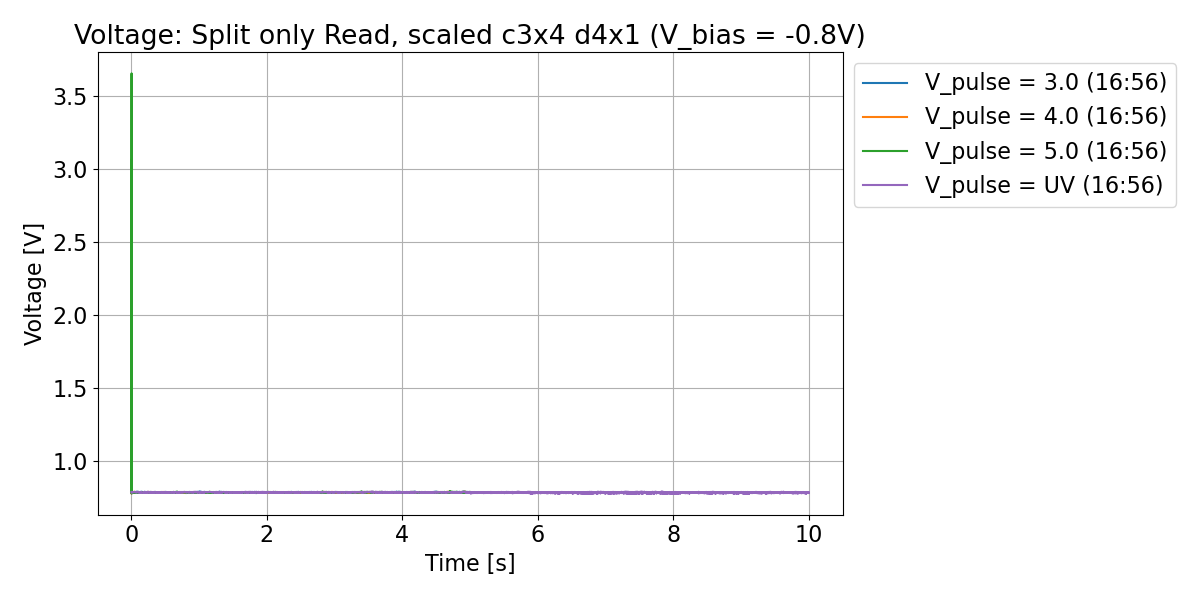

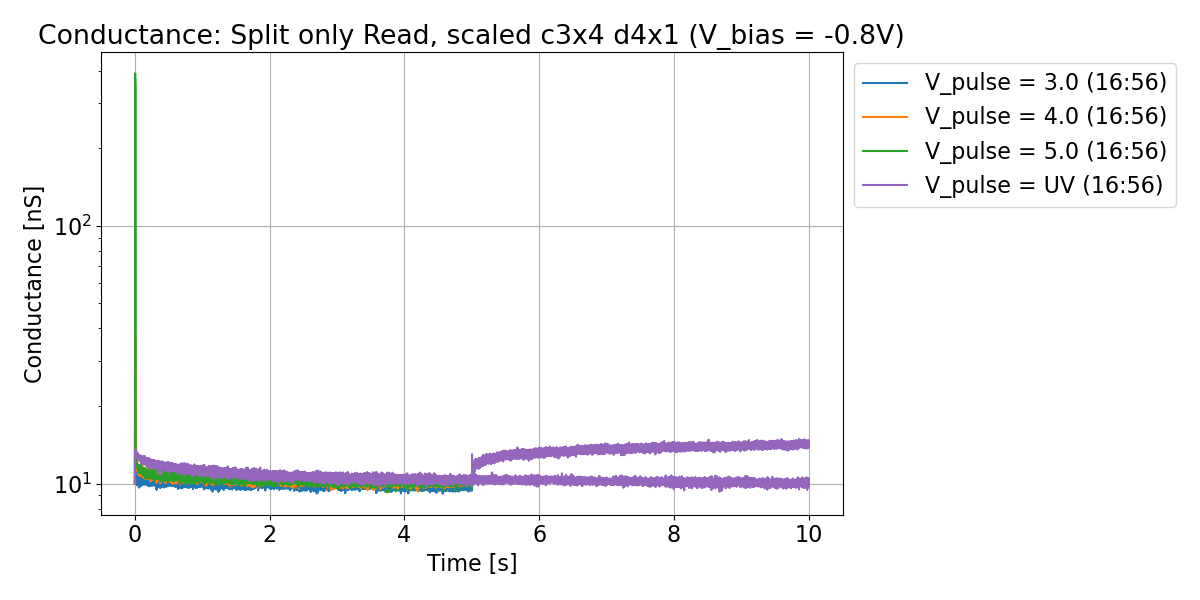

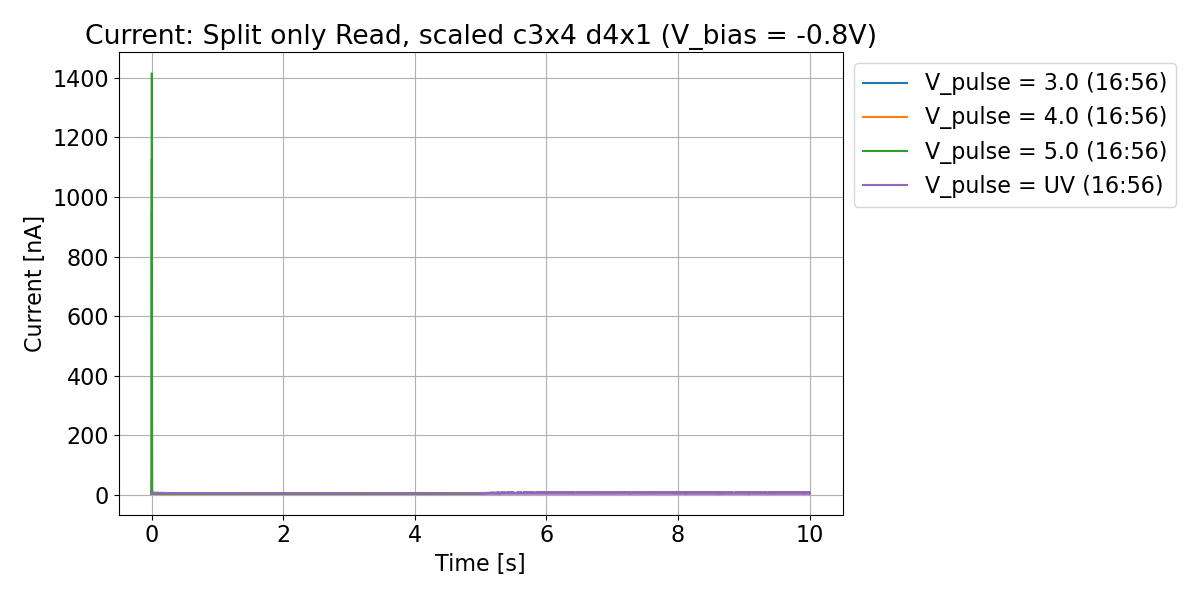

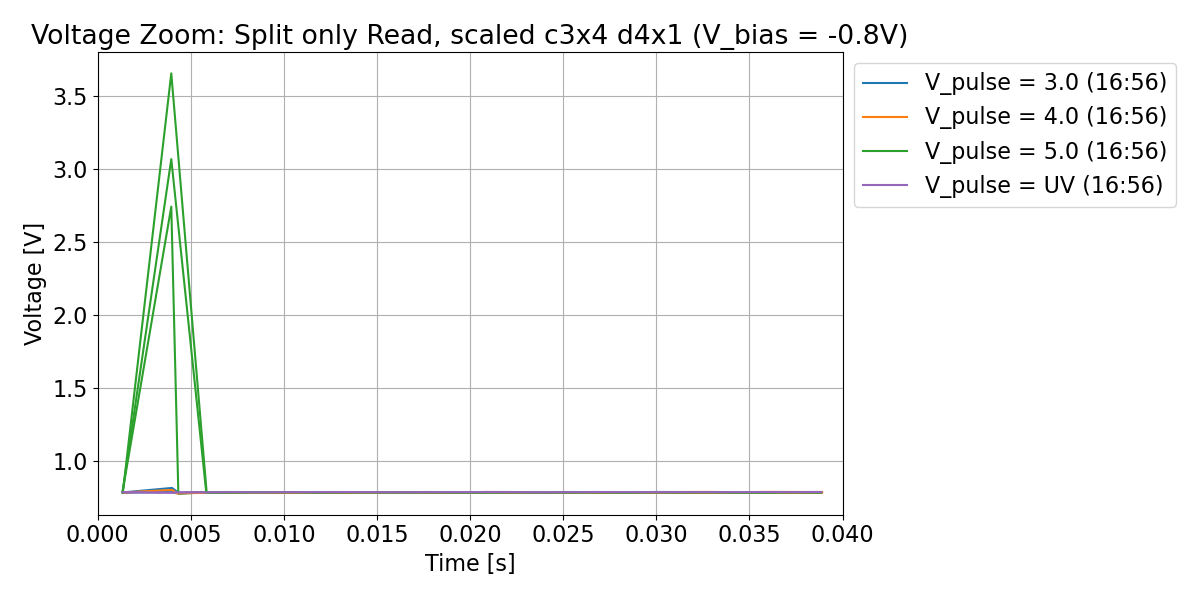

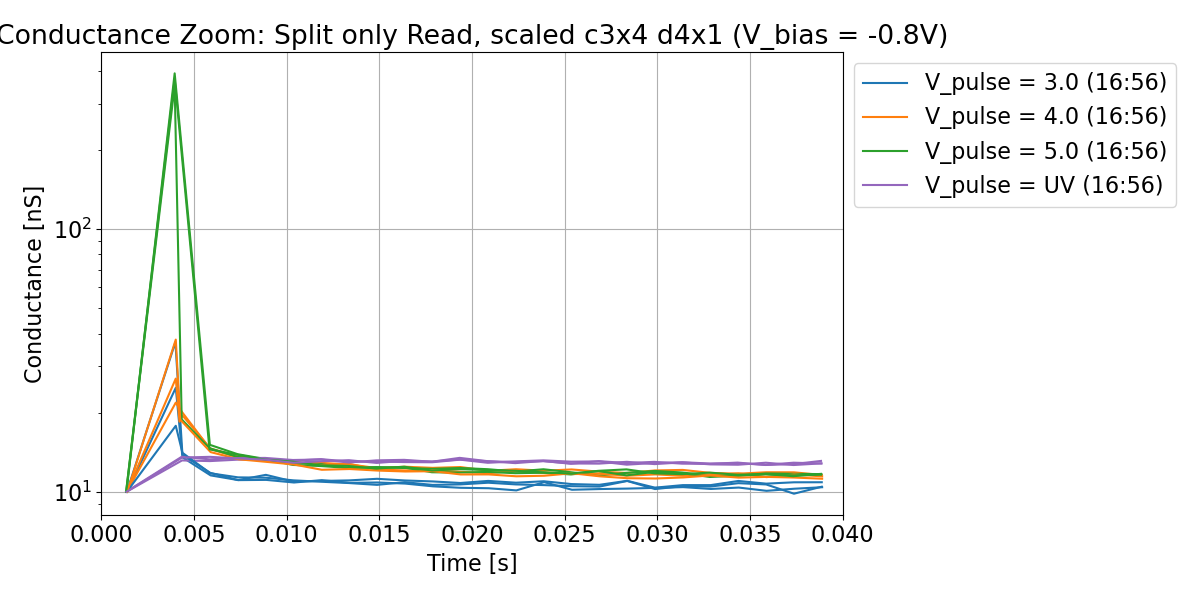

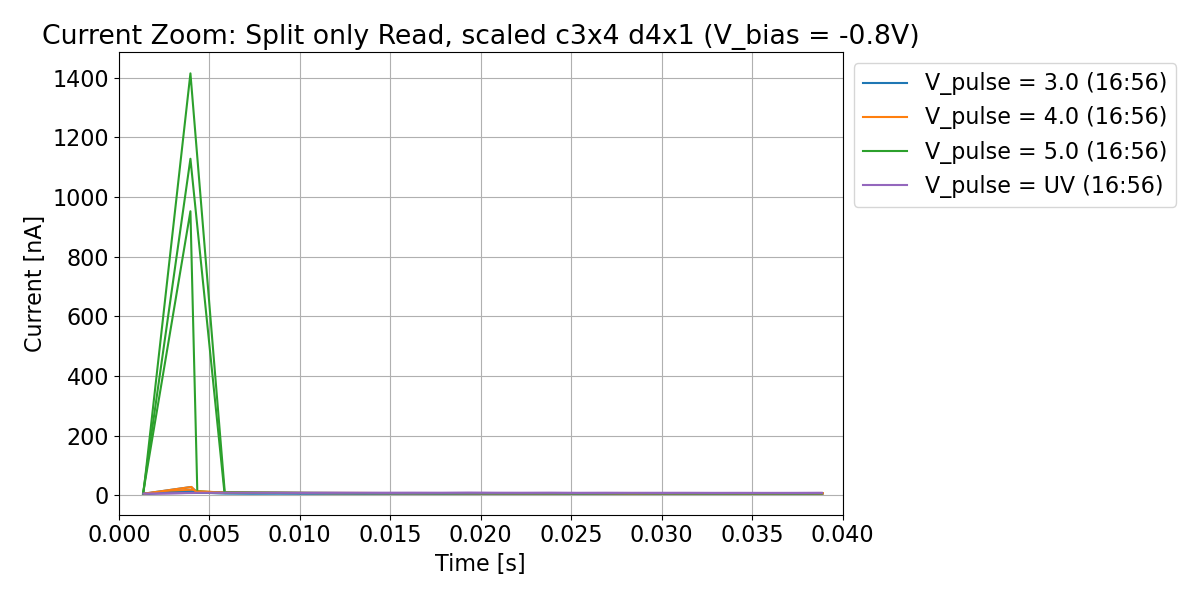

In [131]:
plt.close('all')

figures = []
figure_names = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for spec in figure_specs:
        figsize_labelled = list(figsize)
        figsize_labelled[0] = figsize[0] * (1+figsize_factor*int(legend_pos == 'outside'))
        if spec['no_labels']:
            fig, axs = plt.subplots(1,1, figsize=figsize)
        else:
            fig, axs = plt.subplots(1,1, figsize=figsize_labelled)
        
        for i, idx in enumerate(plot_selection):
            m = an.measurements[idx]
            data = m['data'].iloc[::interleave]      
            x = data[spec['x_axis']]
            y = data[spec['y_axis']]
            if 'abs' in spec and spec['abs']:
                y = y.abs()
            if spec['xlim'].size:
                mask = (x >= spec['xlim'][0]) & (x <= spec['xlim'][1])
                x = x[mask]
                y = y[mask]
    
            color = color_map(cmap, i)
            if max_legend_entries is None or i < max_legend_entries:
                label = _parse_template(m, spec['legend_template'])
            else:
                label = '_no_label_'
            y_factor = spec['yfactor']
            axs.plot(x, y*y_factor, color=color, linestyle=linestyle_map[i], label=label);


        axs.set_xscale(spec['xscale'])
        axs.set_yscale(spec['yscale'])

        if spec['xlim'].size:
            axs.set_xlim(tuple(spec['xlim']))
        if spec['ylim'].size:
            axs.set_ylim(tuple(spec['ylim'] * y_factor))


        name = _parse_template(an.measurements[plot_selection[0]], spec['title'])
        figure_names.append(name)
        if not spec['no_labels']:
            legend_kwargs = {}
            if legend_pos == 'outside':
                legend_kwargs['bbox_to_anchor'] = (1,1)
                legend_kwargs['loc'] = 'upper left'
            else:
                legend_kwargs['loc'] = legend_pos
            
            if legend_labels:
                axs.legend(legend_labels, **legend_kwargs)
            else:
                axs.legend(**legend_kwargs)
                
            axs.set_xlabel(spec['x_axis'] + ' ' + units[spec['x_axis']])
            axs.set_ylabel(spec['y_axis'] + ' ' + units[spec['y_axis']])
            axs.set_title(name)
            axs.grid()

        
       
        
        fig.tight_layout()
        figures.append(fig)

### Save figures 

In [194]:
savenames = figure_names
subdirectory = 'clean'
save_figures(figures, figure_specs, savenames, directory, subdirectory=subdirectory, filetype='pdf')

/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Voltage_Split_only_Read__scaled_c3x4_d4x1_V_bias_=_0_8V
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Conductance_Split_only_Read__scaled_c3x4_d4x1_V_bias_=_0_8V_ylog
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Current_Split_only_Read__scaled_c3x4_d4x1_V_bias_=_0_8V
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Voltage_Zoom_Split_only_Read__scaled_c3x4_d4x1_V_bias_=_0_8V_x=0E+00_to_4E-02
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Conductance_Zoom_Split_only_Read__scaled_c3x4_d4x1_V_bias_=_0_8V_ylog_x=0E+00_to_4E-02
/baltic/users/optolabda

# Plot different biases 

In [328]:
selection = selection
selection = [0]

chosen_sel = 'normal'
chosen_sel = 'split_selections'
chosen_sel = 'triggered_selections'
chosen_sel = 'scaled_selections'
#chosen_sel = 'mov_avg_selections'

In [357]:
choose_split = True
#split_idces = list(range(1, 58, 4)) # V_pulse = 3V
# split_idces = list(range(2, 59, 4)) # V_pulse = 4V
split_idces = list(range(3, 60, 4)) # V_pulse = 5V
#split_idces = list(range(4, 61, 4)) # UV pulse


plot_selection = []

for idx in selection:
    man_sel = an.manipulated_selections[chosen_sel][idx]
    if choose_split:
        man_sel = [s for i,s in enumerate(man_sel) if i in split_idces]
        
    plot_selection += man_sel

In [358]:
print(plot_selection)

['0_split_4_trig_scaled', '0_split_8_trig_scaled', '0_split_12_trig_scaled', '0_split_16_trig_scaled', '0_split_20_trig_scaled', '0_split_24_trig_scaled', '0_split_28_trig_scaled', '0_split_32_trig_scaled', '0_split_36_trig_scaled', '0_split_40_trig_scaled', '0_split_44_trig_scaled', '0_split_48_trig_scaled', '0_split_52_trig_scaled', '0_split_56_trig_scaled', '0_split_60_trig_scaled']


### Plot Setup 

In [359]:
# Data Range
interleave = 1

xlim = [0, 0.04]

y_factor = 1e9

In [360]:
# Plot Design
figsize = (8,6)

figsize_factor = 0.5

font = {'weight' : 'normal',
        'size'   : 16}
        
plt.rc('font', **font)

cmap = plt.cm.get_cmap('tab10')
def color_map(cmap, i):
    # mapping = list(range(10))
    # mapping = [2, 3, 2, 3]
    mapping = [0,0,0,1,1,1,2,2,2,3,3,3,4,4,4]
    #mapping = None
    if mapping is None or int(i) >= len(mapping):
        return cmap(int(i)%10)
    elif type(mapping[int(i)]) is int:     
        return cmap(mapping[int(i)])
    else:
        return mapping[int(i)]

# def color_map(cmap, i):
#     return colors[i]


linestyle_map = ['-']*100
#linestyle_map = ['--', '--', '-', '-', '-', '--', '-', '--', '-', '--']

In [361]:
# Labels
no_labels = False

title_template = 'Split only Read, scaled {cluster} {device} (V_pulse = {V_pulse}V)'
#title_template = 'DC'

units = {'Conductance': '[nS]', 'Time': '[s]', 'Voltage': '[V]', 'Current': '[nA]'}


legend_template = 'V_bias = {V_bias}V ({timestamp:%H:%M})'

legend_labels = []

max_legend_entries = None

legend_pos = 'outside'
#legend_pos = 'best'
#legend_pos = 'upper right'



In [362]:
# Figure specification
figure_specs = [
    {
        'title': 'Voltage: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Voltage',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array([]),
        'ylim': np.array([]),
        'yfactor': 1,
        'legend_template': legend_template,
        'no_labels': no_labels
    },
    {
        'title': 'Conductance: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Conductance',
        'abs': False,
        'xscale': 'log',
        'yscale': 'log',
        'xlim': np.array([1e-3, 5.5]),
        'ylim': np.array([9e-9, 22e-9]), #[9e-9, 30e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels
    },
    {
        'title': 'Current: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Current',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array([]),
        'ylim': np.array([]), # [4e-9, 20e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels
    },    
    {
        'title': 'Voltage Zoom: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Voltage',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array(xlim),
        'ylim': np.array([]),
        'yfactor': 1,
        'legend_template': legend_template,
        'no_labels': no_labels
    },
    {
        'title': 'Conductance Zoom: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Conductance',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'log',
        'xlim': np.array(xlim),
        'ylim': np.array([]), #[9e-9, 30e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels
    },
    {
        'title': 'Current Zoom: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Current',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array(xlim),
        'ylim': np.array([]), # [4e-9, 20e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels
    },    
]   

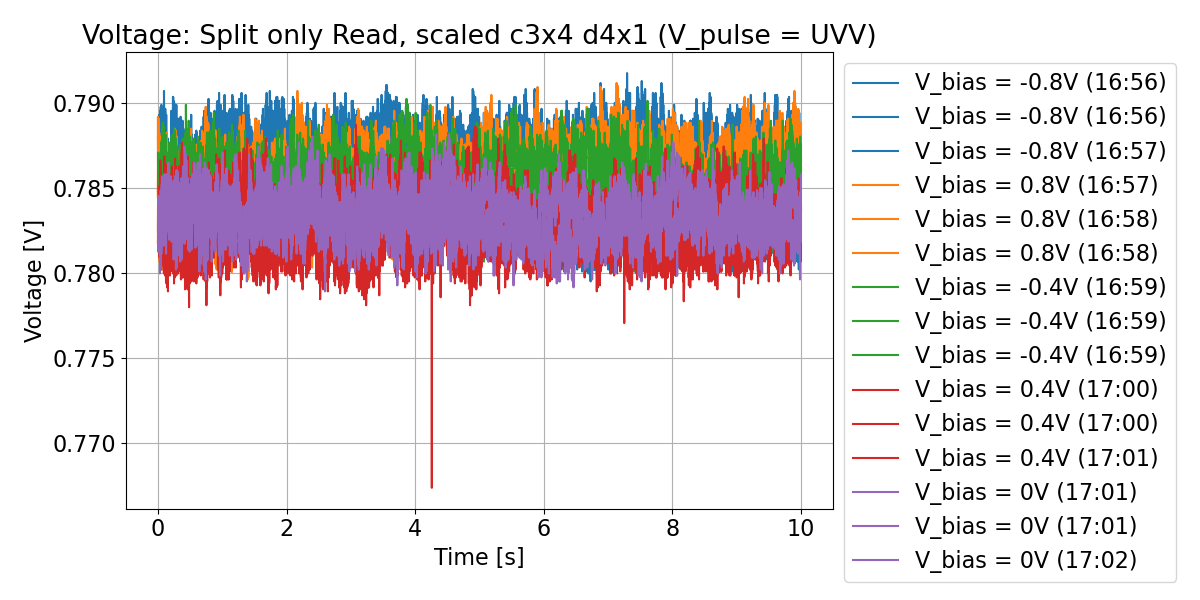

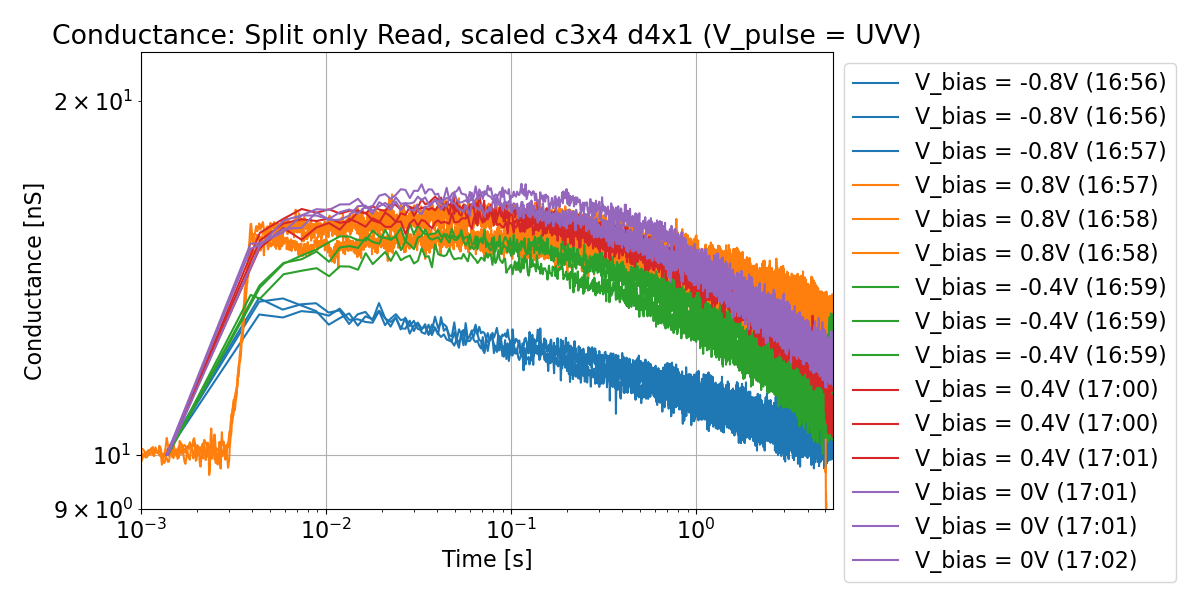

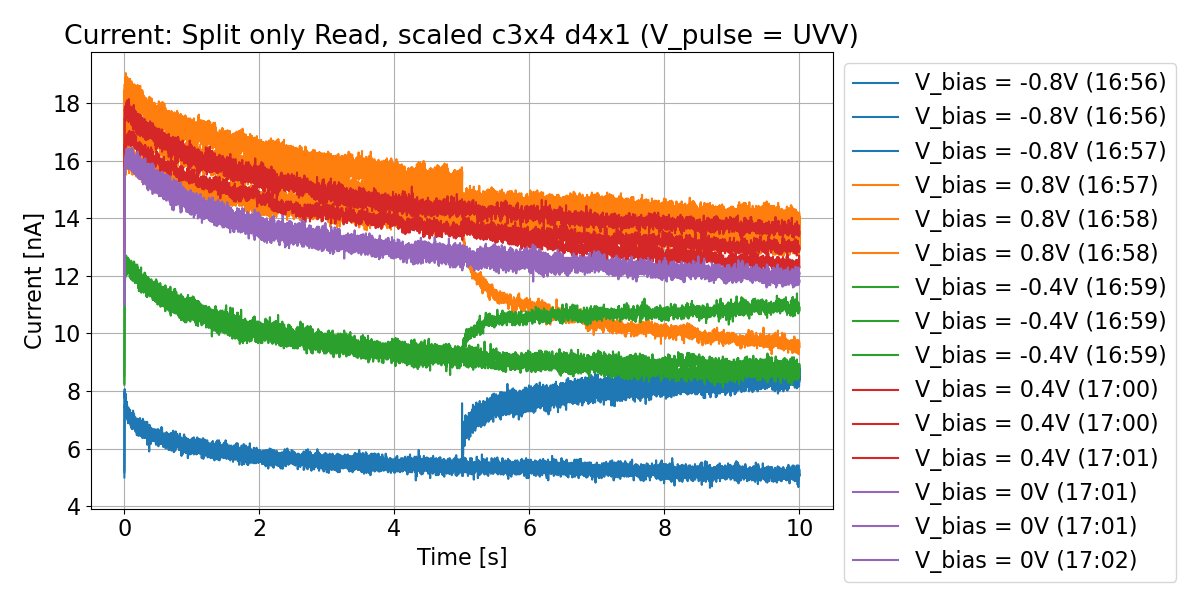

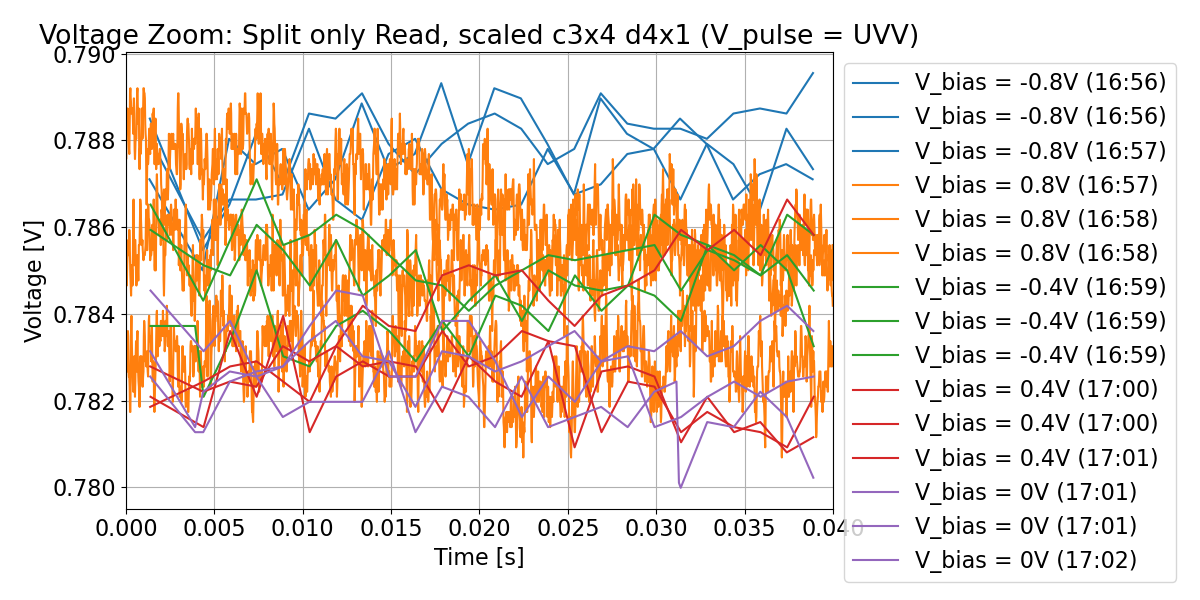

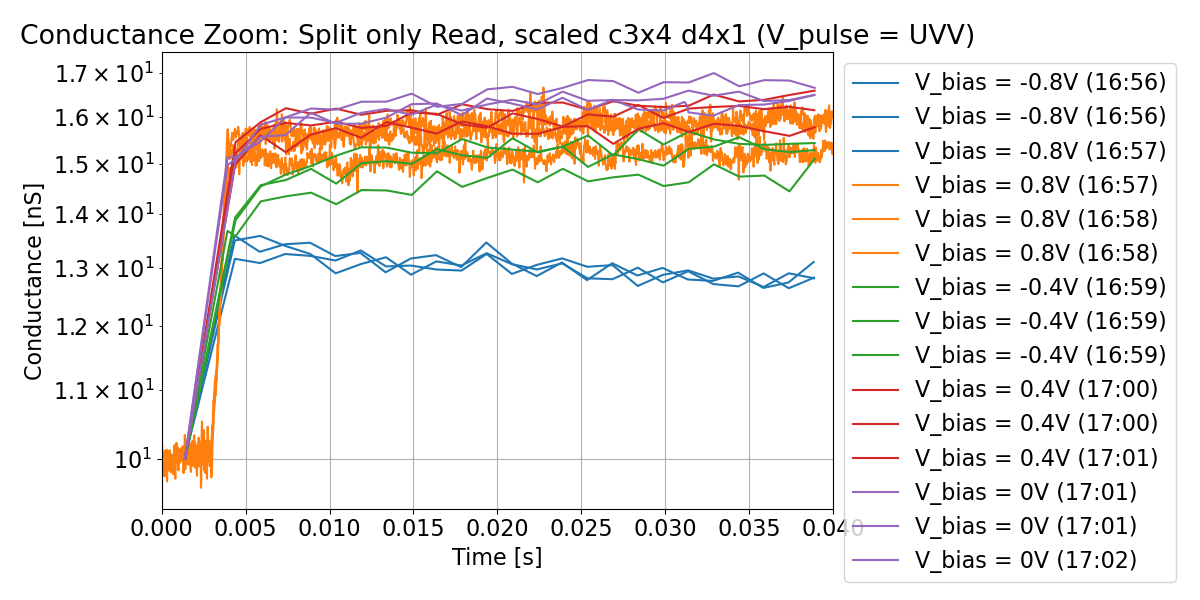

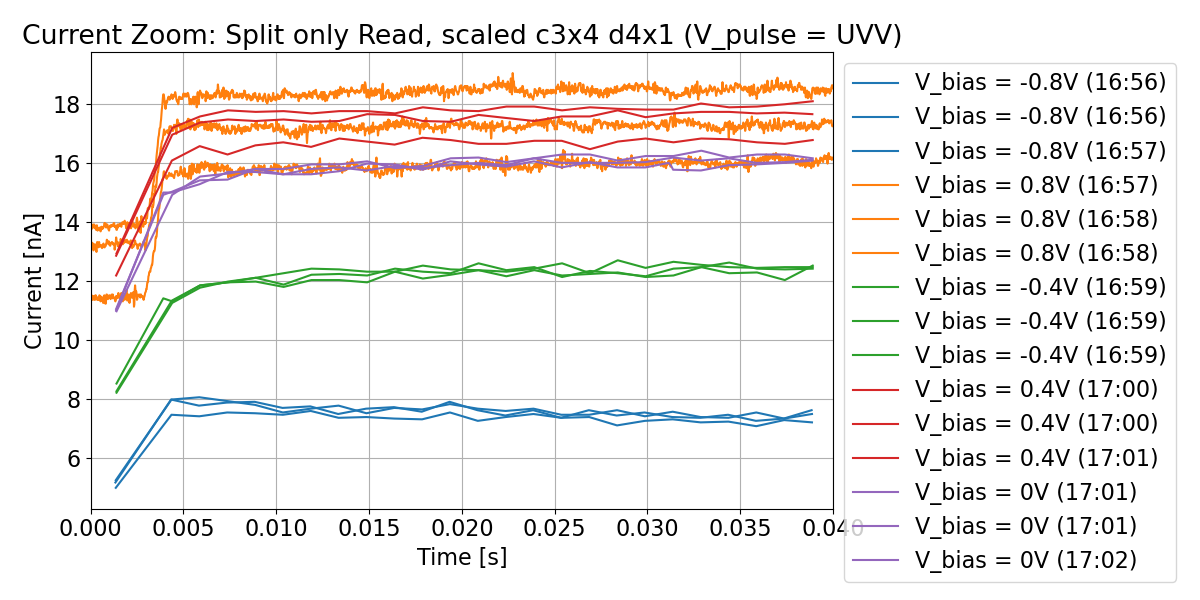

In [363]:
plt.close('all')

figures = []
figure_names = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for spec in figure_specs:
        figsize_labelled = list(figsize)
        figsize_labelled[0] = figsize[0] * (1+figsize_factor*int(legend_pos == 'outside'))
        if spec['no_labels']:
            fig, axs = plt.subplots(1,1, figsize=figsize)
        else:
            fig, axs = plt.subplots(1,1, figsize=figsize_labelled)
        
        for i, idx in enumerate(plot_selection):
            m = an.measurements[idx]
            data = m['data'].iloc[::interleave]      
            x = data[spec['x_axis']]
            y = data[spec['y_axis']]
            if 'abs' in spec and spec['abs']:
                y = y.abs()
            if spec['xlim'].size:
                mask = (x >= spec['xlim'][0]) & (x <= spec['xlim'][1])
                x = x[mask]
                y = y[mask]
    
            color = color_map(cmap, i)
            if max_legend_entries is None or i < max_legend_entries:
                label = _parse_template(m, spec['legend_template'])
            else:
                label = '_no_label_'
            y_factor = spec['yfactor']
            axs.plot(x, y*y_factor, color=color, linestyle=linestyle_map[i], label=label);


        axs.set_xscale(spec['xscale'])
        axs.set_yscale(spec['yscale'])

        if spec['xlim'].size:
            axs.set_xlim(tuple(spec['xlim']))
        if spec['ylim'].size:
            axs.set_ylim(tuple(spec['ylim'] * y_factor))


        name = _parse_template(an.measurements[plot_selection[0]], spec['title'])
        figure_names.append(name)
        if not spec['no_labels']:
            legend_kwargs = {}
            if legend_pos == 'outside':
                legend_kwargs['bbox_to_anchor'] = (1,1)
                legend_kwargs['loc'] = 'upper left'
            else:
                legend_kwargs['loc'] = legend_pos
            
            if legend_labels:
                axs.legend(legend_labels, **legend_kwargs)
            else:
                axs.legend(**legend_kwargs)
                
            axs.set_xlabel(spec['x_axis'] + ' ' + units[spec['x_axis']])
            axs.set_ylabel(spec['y_axis'] + ' ' + units[spec['y_axis']])
            axs.set_title(name)
            axs.grid()

        
       
        
        fig.tight_layout()
        figures.append(fig)

### Save figures 

In [ ]:
savenames = figure_names
subdirectory = 'clean'
save_figures(figures, figure_specs, savenames, directory, subdirectory=subdirectory, filetype='pdf')

/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Voltage_Split_only_Read__scaled_c3x4_d4x1_V_bias_=_0_8V
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Conductance_Split_only_Read__scaled_c3x4_d4x1_V_bias_=_0_8V_ylog
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Current_Split_only_Read__scaled_c3x4_d4x1_V_bias_=_0_8V
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Voltage_Zoom_Split_only_Read__scaled_c3x4_d4x1_V_bias_=_0_8V_x=0E+00_to_4E-02
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Conductance_Zoom_Split_only_Read__scaled_c3x4_d4x1_V_bias_=_0_8V_ylog_x=0E+00_to_4E-02
/baltic/users/optolabda

In [367]:
# ToDo

# Plot different biases: mean and standard deviation

In [130]:
selection = selection
selection = [0]

chosen_sel = 'normal'
chosen_sel = 'split_selections'
chosen_sel = 'triggered_selections'
chosen_sel = 'scaled_selections'
#chosen_sel = 'mov_avg_selections'

In [131]:
choose_split = True

# # V_pulse = 3V
# split_idces = [
#     [1, 5, 9],
#     [13, 17, 21],
#     [25, 29, 33],
#     [37, 41, 45],
#     [49, 53, 57]
# ]

# # V_pulse = 4V
# split_idces = [
#     list(np.array([1, 5, 9])+1),
#     list(np.array([13, 17, 21])+1),
#     list(np.array([25, 29, 33])+1),
#     list(np.array([37, 41, 45])+1),
#     list(np.array([49, 53, 57])+1),
# ]

# V_pulse = 5V
split_idces = [
    list(np.array([1, 5, 9])+2),
    list(np.array([13, 17, 21])+2),
    list(np.array([25, 29, 33])+2),
    list(np.array([37, 41, 45])+2),
    list(np.array([49, 53, 57])+2),
]

# # V_pulse = UV
# split_idces = [
#     list(np.array([1, 5, 9])+3),
#     list(np.array([13, 17, 21])+3),
#     list(np.array([25, 29, 33])+3),
#     list(np.array([37, 41, 45])+3),
#     list(np.array([49, 53, 57])+3),
# ]


In [132]:
plot_selection = []

for idx in selection:
    man_sel = an.manipulated_selections[chosen_sel][idx]
    if choose_split:
        for spl_row in split_idces:
            sub_sel = [s for i,s in enumerate(man_sel) if i in spl_row]
            plot_selection.append(sub_sel)      
        
    

In [133]:
print(plot_selection)

[['0_split_3_trig_scaled', '0_split_7_trig_scaled', '0_split_11_trig_scaled'], ['0_split_15_trig_scaled', '0_split_19_trig_scaled', '0_split_23_trig_scaled'], ['0_split_27_trig_scaled', '0_split_31_trig_scaled', '0_split_35_trig_scaled'], ['0_split_39_trig_scaled', '0_split_43_trig_scaled', '0_split_47_trig_scaled'], ['0_split_51_trig_scaled', '0_split_55_trig_scaled', '0_split_59_trig_scaled']]


## Calculate Mean and Std Deviation

In [134]:
selection_means, selection_stds = an.calc_errorbars(plot_selection)

In [143]:
selection_means

['0_0_0_split_11_trig_scaled_mean',
 '0_0_0_split_23_trig_scaled_mean',
 '0_0_0_split_35_trig_scaled_mean',
 '0_0_0_split_47_trig_scaled_mean',
 '0_0_0_split_59_trig_scaled_mean']

### Plot Setup 

In [147]:
# Data Range
interleave = 1

xlim = [0, 0.04]

y_factor = 1e9

In [148]:
# Plot Design
figsize = (8,6)

figsize_factor = 0.5

font = {'weight' : 'normal',
        'size'   : 16}
        
plt.rc('font', **font)

cmap = plt.cm.get_cmap('tab10')
def color_map(cmap, i):
    # mapping = list(range(10))
    # mapping = [2, 3, 2, 3]
    mapping = [0,0,0,1,1,1,2,2,2,3,3,3,4,4,4]
    mapping = None
    if mapping is None or int(i) >= len(mapping):
        return cmap(int(i)%10)
    elif type(mapping[int(i)]) is int:     
        return cmap(mapping[int(i)])
    else:
        return mapping[int(i)]

# def color_map(cmap, i):
#     return colors[i]


linestyle_map = ['-']*100
#linestyle_map = ['--', '--', '-', '-', '-', '--', '-', '--', '-', '--']

In [149]:
# Labels
no_labels = False

title_template = 'Split only Read, scaled {cluster} {device} (V_pulse = {V_pulse}V)'
#title_template = 'DC'

units = {'Conductance': '[nS]', 'Time': '[s]', 'Voltage': '[V]', 'Current': '[nA]'}


legend_template = 'V_bias = {V_bias}V ({timestamp:%H:%M})'

legend_labels = []

max_legend_entries = None

legend_pos = 'outside'
#legend_pos = 'best'
#legend_pos = 'upper right'



In [150]:
# Figure specification
figure_specs = [
    {
        'title': 'Voltage: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Voltage',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array([]),
        'ylim': np.array([]),
        'yfactor': 1,
        'legend_template': legend_template,
        'no_labels': no_labels,
        'errorbar_plot': False
    },
    {
        'title': 'Conductance: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Conductance',
        'abs': False,
        'xscale': 'log',
        'yscale': 'log',
        'xlim': np.array([1e-3, 5.5]),
        'ylim': np.array([9e-9, 22e-9]), #[9e-9, 30e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels,
        'errorbar_plot': False
    },
    {
        'title': 'Current: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Current',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array([]),
        'ylim': np.array([]), # [4e-9, 20e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels,
        'errorbar_plot': False
    },    
    {
        'title': 'Voltage Zoom: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Voltage',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array(xlim),
        'ylim': np.array([]),
        'yfactor': 1,
        'legend_template': legend_template,
        'no_labels': no_labels,
        'errorbar_plot': False
    },
    {
        'title': 'Conductance Zoom: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Conductance',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'log',
        'xlim': np.array(xlim),
        'ylim': np.array([]), #[9e-9, 30e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels,
        'errorbar_plot': False
    },
    {
        'title': 'Current Zoom: ' + title_template,
        'x_axis': 'Time',
        'y_axis': 'Current',
        'abs': False,
        'xscale': 'linear',
        'yscale': 'linear',
        'xlim': np.array(xlim),
        'ylim': np.array([]), # [4e-9, 20e-9]
        'yfactor': y_factor,
        'legend_template': legend_template,
        'no_labels': no_labels,
        'errorbar_plot': False
    },    
]   

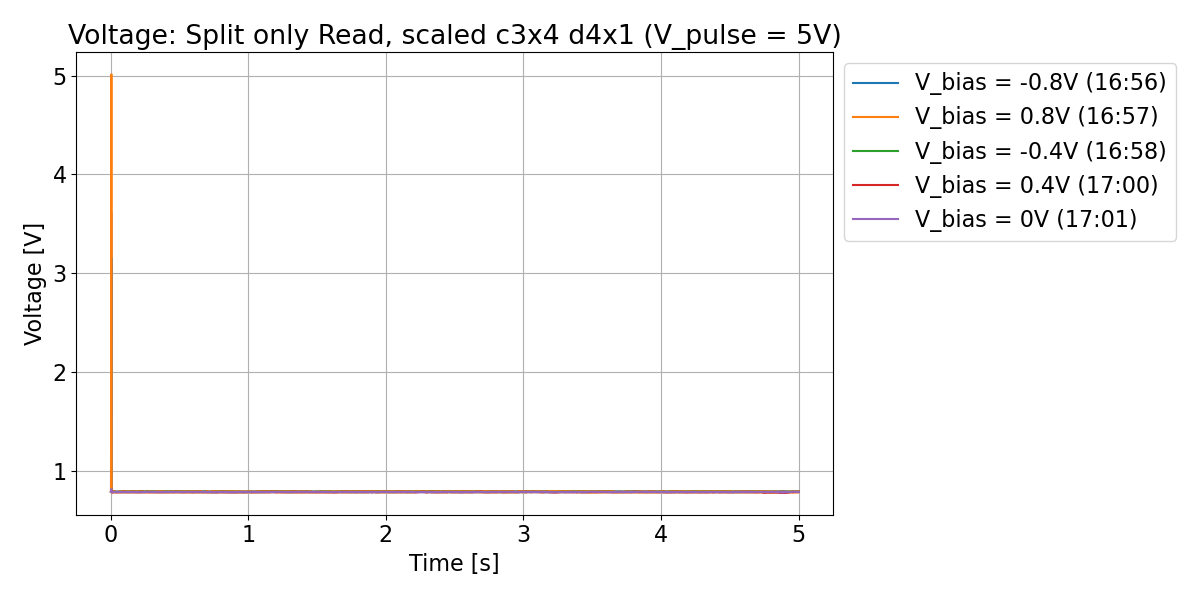

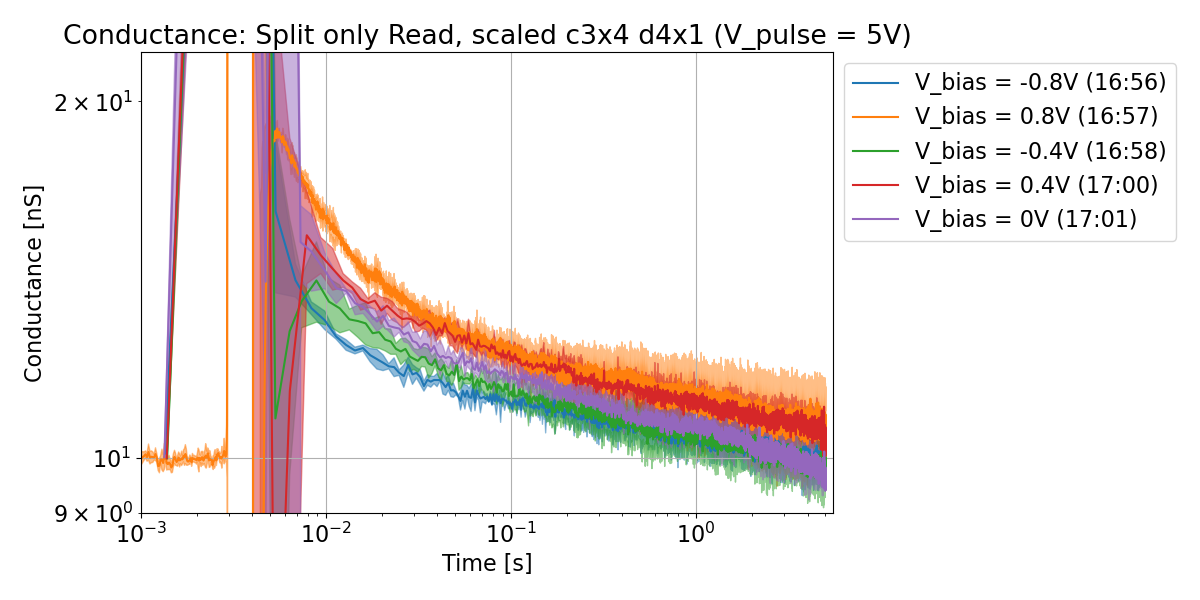

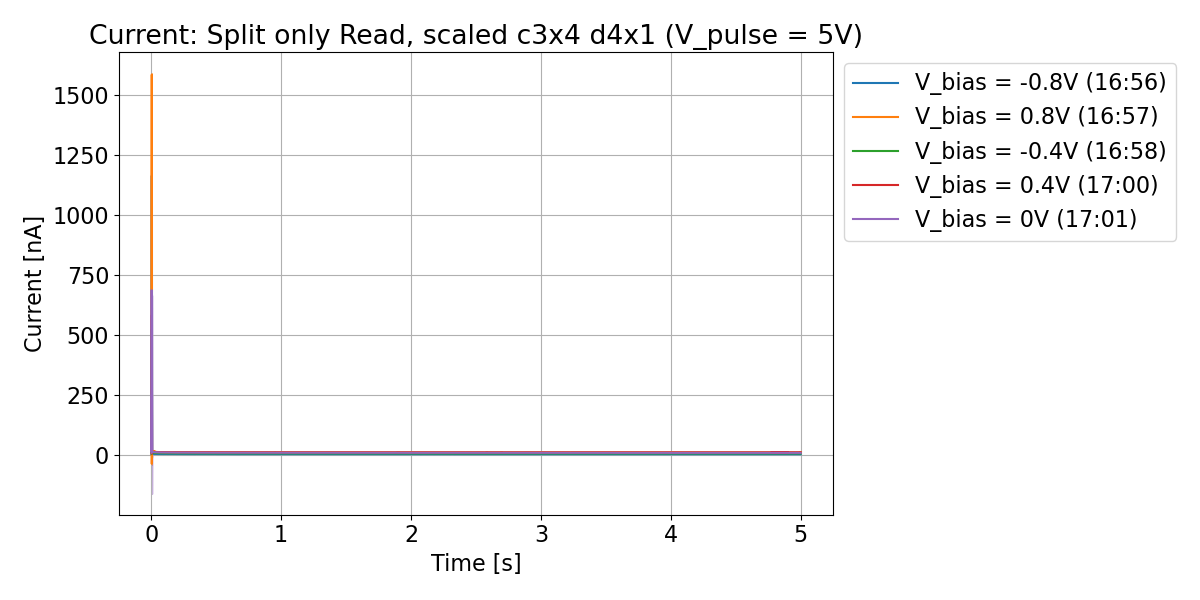

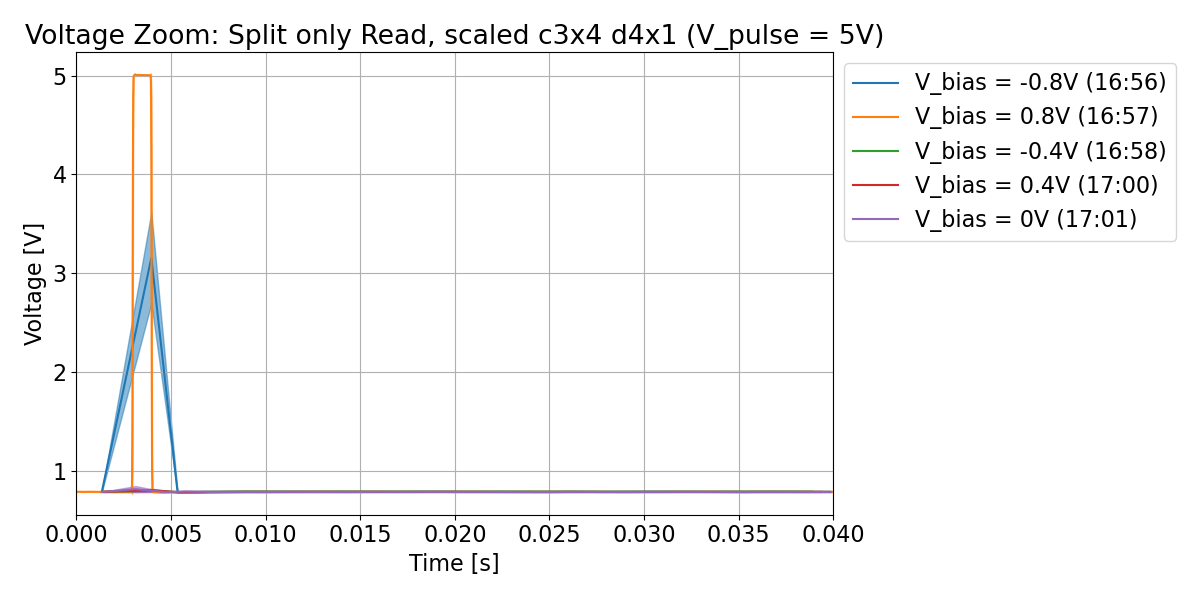

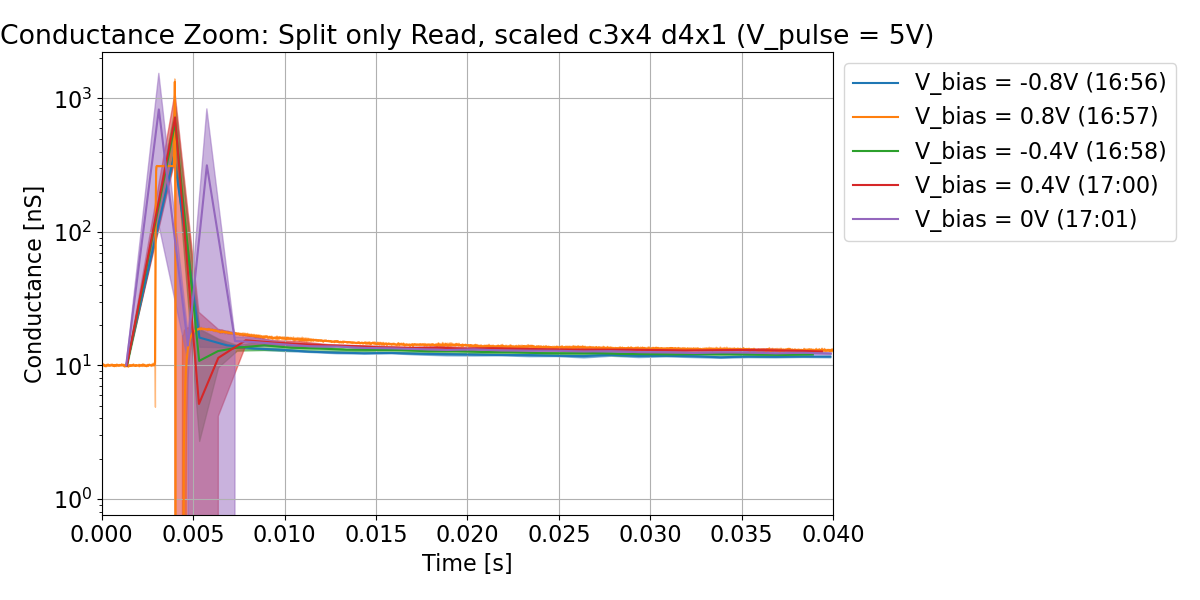

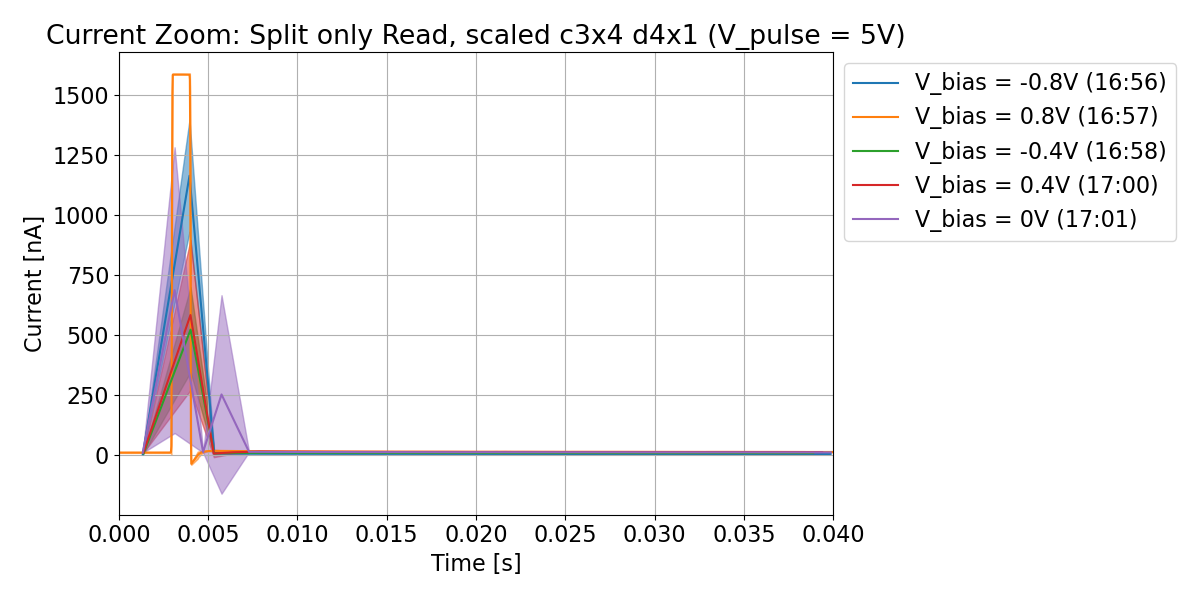

In [151]:
plt.close('all')

figures = []
figure_names = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for spec in figure_specs:
        figsize_labelled = list(figsize)
        figsize_labelled[0] = figsize[0] * (1+figsize_factor*int(legend_pos == 'outside'))
        if spec['no_labels']:
            fig, axs = plt.subplots(1,1, figsize=figsize)
        else:
            fig, axs = plt.subplots(1,1, figsize=figsize_labelled)
        
        for i, (id_mean, id_std) in enumerate(zip(selection_means, selection_stds)):
            m_mean = an.measurements[id_mean]
            data_mean = m_mean['data'].iloc[::interleave]      
            x = data_mean[spec['x_axis']]
            y = data_mean[spec['y_axis']]
            m_std = an.measurements[id_std]
            data_std = m_std['data'].iloc[::interleave]
            y_err = data_std[spec['y_axis']]
            if 'abs' in spec and spec['abs']:
                y = y.abs()
            if spec['xlim'].size:
                mask = (x >= spec['xlim'][0]) & (x <= spec['xlim'][1])
                x = x[mask]
                y = y[mask]
                y_err = y_err[mask]
    
            color = color_map(cmap, i)
            if max_legend_entries is None or i < max_legend_entries:
                label = _parse_template(m_mean, spec['legend_template'])
            else:
                label = '_no_label_'
            y_factor = spec['yfactor']
        
            if 'errorbar_plot' in spec and spec['errorbar_plot']:
                axs.errorbar(x, y*y_factor, yerr=y_err*y_factor, color=color, label=label);
            else:
                axs.plot(x, y*y_factor, color=color, linestyle=linestyle_map[i], label=label)
                axs.fill_between(x, (y-y_err)*y_factor, (y+y_err)*y_factor, color=color, alpha=0.5, label='_no_label_')


        axs.set_xscale(spec['xscale'])
        axs.set_yscale(spec['yscale'])

        if spec['xlim'].size:
            axs.set_xlim(tuple(spec['xlim']))
        if spec['ylim'].size:
            axs.set_ylim(tuple(spec['ylim'] * y_factor))


        name = _parse_template(an.measurements[plot_selection[0][0]], spec['title'])
        figure_names.append(name)
        if not spec['no_labels']:
            legend_kwargs = {}
            if legend_pos == 'outside':
                legend_kwargs['bbox_to_anchor'] = (1,1)
                legend_kwargs['loc'] = 'upper left'
            else:
                legend_kwargs['loc'] = legend_pos
            
            if legend_labels:
                if 'errorbar_plot' in spec and spec['errorbar_plot']:
                    pass
                else:
                    legend_labels = sum([[l, '_no_label_'] for l in legend_labels], [])
                axs.legend(legend_labels, **legend_kwargs)
            else:
                axs.legend(**legend_kwargs)
            
            axs.set_xlabel(spec['x_axis'] + ' ' + units[spec['x_axis']])
            axs.set_ylabel(spec['y_axis'] + ' ' + units[spec['y_axis']])
            axs.set_title(name)
            axs.grid()

        
       
        
        fig.tight_layout()
        figures.append(fig)

### Save figures 

In [ ]:
savenames = figure_names
subdirectory = 'clean'
save_figures(figures, figure_specs, savenames, directory, subdirectory=subdirectory, filetype='pdf')

/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Voltage_Split_only_Read__scaled_c3x4_d4x1_V_bias_=_0_8V
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Conductance_Split_only_Read__scaled_c3x4_d4x1_V_bias_=_0_8V_ylog
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Current_Split_only_Read__scaled_c3x4_d4x1_V_bias_=_0_8V
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Voltage_Zoom_Split_only_Read__scaled_c3x4_d4x1_V_bias_=_0_8V_x=0E+00_to_4E-02
/baltic/users/optolabdata/Experiments/ChristophWeilenmann/2024-05-02_cleansweep_5_before_anneal_pulses_short_measurement/clean/Conductance_Zoom_Split_only_Read__scaled_c3x4_d4x1_V_bias_=_0_8V_ylog_x=0E+00_to_4E-02
/baltic/users/optolabda

### Pick Points 0.6V

In [ ]:
# act_on_selections = 'split_selections'

In [ ]:
# if not 'triggered_selections' in an.manipulated_selections:
#     an.manipulated_selections['triggered_selections'] = {}
    
# skip_known = False

In [ ]:
# chosen_triggered_sel = 0
# appendix = 'pick_t'

# selection_pick_t = []
# for i, sel in enumerate(an.manipulated_selections['triggered_selections'][chosen_triggered_sel]):
#     if i == 0:
#         continue
#     timestamps = an.measurements[sel]['data']['Time']
#     idx_0_6 = an.manipulated_selections[act_on_selections][6][i]
#     m = copy.deepcopy(an.measurements[idx_0_6])
#     data_0_6 = m['data']
#     merged_df = pd.merge_asof(timestamps, data_0_6, on='Time', direction='nearest')
#     m['data'] = merged_df
#     new_idx_0_6 = f'{idx_0_6}_{appendix}'
#     print(new_idx_0_6)
#     an.measurements[new_idx_0_6] = m
#     selection_pick_t.append(new_idx_0_6)
    
# an.manipulated_selections['triggered_selections'][6] = selection_pick_t